## **Исследование факторов открытия депозита в банке**

**Задача:**

Банк провел маркетинговую кампанию привлечения клиентов для открытия депозита. Необходимо проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент открыл депозит.

In [568]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import IsolationForest, GradientBoostingClassifier

import optuna

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-dark')


### Знакомство с данными, обработка пропусков и выбросов

*Данные о клиентах банка:*

* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).

*Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:*

* campaign (количество контактов с этим клиентом в течение текущей кампании);
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).

*Прочие признаки:*

* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

*Целевая переменная:*

* deposit (согласится ли клиент открыть депозит в банке)

In [569]:
# Загрузка данных
df = pd.read_csv('bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [570]:
#Информация о структуре данных
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB
None


> * В выборке 11162 записи и 17 признаков.
> * Признаки 'job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'contact', 'poutcome' - категориальные, тип 'object', требуется кодирование.
> * В признаке 'balance' есть пропуски данных и требуется преобразование к числовому виду.  
> * Поля 'age', 'day', 'duration', 'campaign', 'pdays', 'previous' - тип int
> * Целевой признак 'deposit' - категориальный, тип 'object' - необходимо преобразование к бинарному.
>
> *В признаках типа 'object' присутствуют значения 'unknown', что можно расссматриваит как пропуски данных*

In [571]:
#Создадим списки факторов
target = 'deposit' # целевой признак
category_features = df.drop(columns=[target, 'balance']).select_dtypes('object').columns.to_list() #Категориальные
numeral_features = df.drop(columns=category_features + [target]).columns.to_list() #Числовые

#### Заполнение пропусков в данных

**Заполнение пропусков признака 'balanse' медианным значением**

In [572]:
# преобразуем поле к типу float
# избавимся от знака доллара, пробелов между цифрами и меняем десятичную запятую на точку 
df['balance'] = df[df['balance'].notnull()]['balance'].apply(
    lambda x: str(x).replace(',','.').replace(' ','')[:-2]).apply(
        lambda x: 0 if str(x) == '' else x)
    
# Конвертируем в тип float
df['balance'] = df['balance'].astype(float)

#Заполним пропуски медианным значением
df['balance'].fillna(df['balance'].median(), inplace=True)

df['balance'].isna().any()

np.False_

**Заполнение значений 'unknown' в категориальных полях**

In [573]:
# Исследуем признаки типа object на наличие категории 'unknown'
        
for i, feature in enumerate(category_features):
    if df[df[feature] == 'unknown'].shape[0] > 0 :
        print(f"В признаке {feature} {round(df[feature].value_counts(normalize=True)['unknown']*100,1)} % значений 'unknown'")

В признаке job 0.6 % значений 'unknown'
В признаке education 4.5 % значений 'unknown'
В признаке contact 21.0 % значений 'unknown'
В признаке poutcome 74.6 % значений 'unknown'


> Признаки, имеющие значения 'unknown':
> * 'job' - 70 (0,6%) - можно заполнить модой.
> * 'education' - 497 (4,5%) - можно заполнить модой.
> * 'contact' - 2346 (21%) - для заполнения необходимы дополнительные данные
> * 'poutcome' - 8326 (74%) - скорее всего, сведений не найти.

In [574]:
# заполнение пропусков в поле 'job'
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x.strip() == 'unknown' else x)

# заполнение пропусков в поле 'education'
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x.strip() == 'unknown' else x)

# проверка
print(df[df['job'] == 'unknown'].shape[0])
print(df[df['education'] == 'unknown'].shape[0])

0
0


#### Исследование и удаление выбросов числовых данных

In [575]:
# Цветовая схема
cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0.2,1,len(numeral_features)))

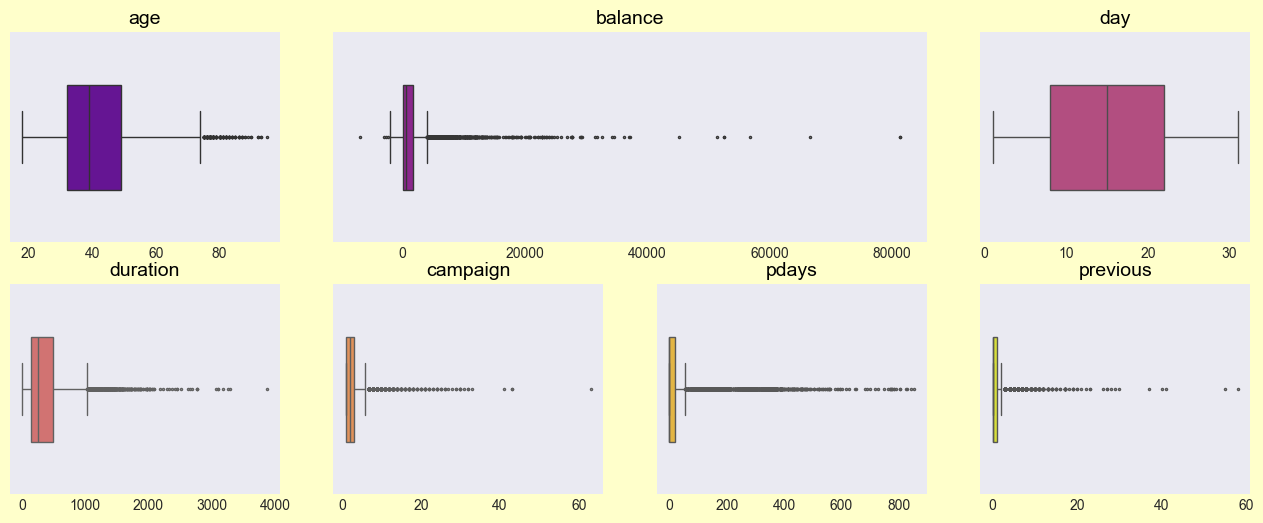

In [576]:
# Выбросы в числовых данных
fig = plt.figure(figsize=(16,6), facecolor='#ffffcb')

shift = 1
for i, feature in enumerate(numeral_features):
    if feature == 'balance':
        shift=2
        ax = fig.add_subplot(2,4,(i+1, i+shift), label=feature)
    else:
        ax = fig.add_subplot(2,4,i+shift, label=feature)
    sns.boxplot(df, x=feature, orient='h',  color=colors[i], width=0.5, fliersize=1.5, ax=ax)
    ax.set_title(feature, fontdict={'size': 14, 'color':'black'})
    ax.set_xlabel('')
plt.show();

> У всех признаков, за исключением признака 'days' есть выбросы. Исследуем их и примем решение об удалении

**Выбросы признака 'age'**

Присутствуют клиенты, возраст которых превышает 90 лет. Исследуем их данные

In [577]:
df[df['age'] > 90]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
1582,95,retired,divorced,primary,no,2282.0,no,no,telephone,21,apr,207,17,-1,0,unknown,yes
2802,92,retired,married,secondary,no,775.0,no,no,cellular,22,oct,313,3,-1,0,unknown,yes
3098,92,retired,married,secondary,no,775.0,no,no,cellular,26,jan,164,4,96,3,success,yes
3756,93,retired,married,secondary,no,775.0,no,no,cellular,22,jul,860,2,177,7,success,yes
3822,93,retired,married,secondary,no,775.0,no,no,cellular,4,aug,476,2,13,9,success,yes


> Судя по записям, все клиенты активны, имеют депозиты, хотя у четверых из них баланс заполнен при восстановлени пропусков данных, с троими был успешный контакт в предыдущую маркетинговую кампанию и есть связь в текущую. Удаление выбросов проводить не надо.

**Выбросы признака 'duration'**

С некоторыми клиентами общение длилось более 3000 секунд (50 минут). Исследуем записи.

In [578]:
df[df['duration'] > 3000]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
153,44,services,divorced,secondary,no,51.0,yes,yes,unknown,27,may,3094,2,-1,0,unknown,yes
271,59,management,married,secondary,no,1321.0,no,no,unknown,9,jun,3881,3,-1,0,unknown,yes
358,28,admin.,single,secondary,no,-7.0,no,yes,unknown,26,jun,3183,2,-1,0,unknown,yes
883,36,self-employed,single,tertiary,no,-103.0,yes,yes,telephone,17,oct,3253,1,-1,0,unknown,yes
1351,47,blue-collar,married,secondary,no,238.0,yes,yes,cellular,13,mar,3076,1,-1,0,unknown,yes
4364,53,admin.,married,secondary,no,849.0,yes,no,cellular,6,feb,3102,3,-1,0,unknown,yes
7198,30,admin.,married,secondary,no,1310.0,no,no,telephone,27,oct,3284,1,-1,0,unknown,no


> У всех клиентов, кроме одного, есть депозиты. У троих клиентов указаны месяц, день и длительность контакта, но способ контакта не указан. Были контакты в предыдущую маркетинговую кампанию, результат неизвестен. Удалять записи не надо.

**Выбросы признака 'campaign'**

С некоторыми клиентами число контактов в текущую кампнию превышает 40. Исследуем записи.

In [579]:
df[df['campaign']>40]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
6927,51,blue-collar,married,secondary,no,41.0,yes,no,telephone,9,jul,16,43,-1,0,unknown,no
7139,42,blue-collar,married,primary,no,170.0,yes,no,unknown,19,may,51,41,-1,0,unknown,no
7240,33,blue-collar,married,secondary,no,0.0,yes,yes,cellular,31,jul,16,43,-1,0,unknown,no
7635,45,management,married,secondary,no,9051.0,yes,no,unknown,19,may,124,63,-1,0,unknown,no


> У всех результаты предыдущей маркетинговой кампании неизвестны, низкий баланс (кроме одного), нет депозитов, но есть кредиты на недвижимость и у одного клиента потребительский кредит. Удалять данные не надо.

**Выбросы признака 'pdays'**

С некоторыми клиентами контакта с предыдущей маркетинговой кампании не было более 2-х лет. Исследуем записи.

In [580]:
df[df['pdays'] > 730]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
3677,37,technician,married,secondary,no,432.0,yes,no,cellular,6,jul,386,3,776,55,failure,yes
3766,37,technician,married,secondary,no,1707.0,yes,no,cellular,26,jul,546,2,784,3,failure,yes
3874,34,blue-collar,married,secondary,no,320.0,yes,no,cellular,12,aug,352,1,828,2,failure,yes
3892,60,services,married,tertiary,no,4256.0,yes,no,cellular,16,aug,239,3,761,1,other,yes
3950,33,unemployed,single,secondary,no,2066.0,no,yes,cellular,9,sep,305,1,749,2,failure,yes
3973,38,management,married,tertiary,no,1477.0,no,no,cellular,15,sep,385,3,769,2,failure,yes
3981,60,retired,married,secondary,no,975.0,no,no,cellular,16,sep,303,1,792,1,failure,yes
3988,37,management,divorced,tertiary,no,488.0,yes,no,cellular,17,sep,328,1,854,2,failure,yes
4001,31,housemaid,married,secondary,no,243.0,yes,no,cellular,23,sep,305,2,842,1,failure,yes
4482,31,blue-collar,married,secondary,no,0.0,yes,no,unknown,10,aug,97,1,782,1,other,yes


> Все клиенты вышли на контакт в текущую маркетинговую кампанию, имеют неотрицательный баланс, большинство имеют депозиты. Удалять не будем.

**Выбросы признака 'balance'**

С некоторыми клиентами контакта с предыдущей маркетинговой кампании не было более 2-х лет. Исследуем записи.

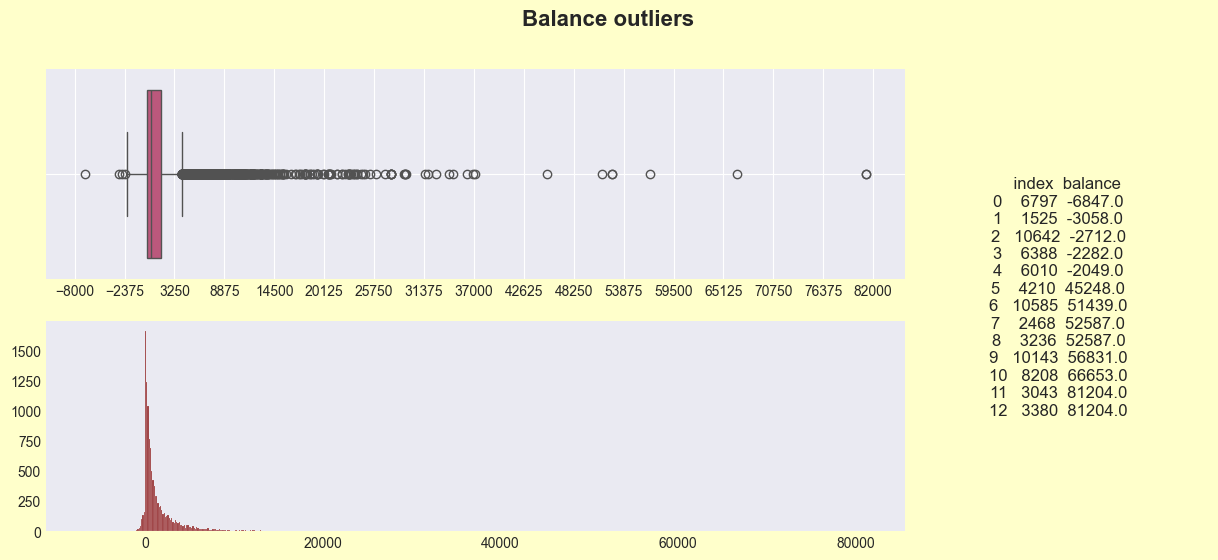

In [581]:
# Распределение признака balance
fig = plt.figure(figsize=(15,6), facecolor='#ffffcb')
fig.suptitle('Balance outliers', fontsize=16, fontweight='bold')
ax1 = fig.add_subplot(2,4,(1,3))
ax3 = fig.add_subplot(2,4,(5,7))
ax2 = fig.add_subplot(1,4,4)
ax2.set_axis_off()
sns.boxplot(df, x='balance', orient='h', palette='plasma', ax=ax1)
ticks = list(np.linspace(-8000,82000, 17).astype('int'))
ax1.set_xticks(ticks)
ax1.set_xlabel('')
ax1.grid(visible=True)
sns.histplot(df, x='balance', cbar=True, color='maroon', edgecolor='white', ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('')
txt = df[(df['balance'] > 40000)|(df['balance'] < -2000)]['balance'].sort_values().reset_index()
fig.text(0.8, 0.5, txt, horizontalalignment='center', verticalalignment='center', fontdict={'size': 12})
plt.show();

> Имеем явные выбросы по признаку 'balance': в отрицательной части шкалы это значения меньшие -2000, в положительной части шкалы - значения, большие 37000. Удалим выбросы.

**Удаление выбросов признака 'balance' методом Тьюки**

In [582]:
#Вычислим границы поиска
IRQ = df['balance'].quantile(0.75) - df['balance'].quantile(0.25)
bottom = df['balance'].quantile(0.25) - 1.5 * IRQ
top = df['balance'].quantile(0.75) + 3 * IRQ # Распределение смещено вправо, отодвинем правую границу 

print(f'{bottom:.0f}, {top:.0f}')

-2241, 6427


In [583]:
# Удалим выбросы
rows_before = df.shape[0]
df.drop(df[(df['balance']<bottom)|(df['balance']>top)].index, axis=0, inplace=True)
print(f'{rows_before - df.shape[0]} rows deleted, the sample shape is', df.shape)

518 rows deleted, the sample shape is (10644, 17)


### Разведывательный анализ данных

#### Соотношение классов целевой переменной

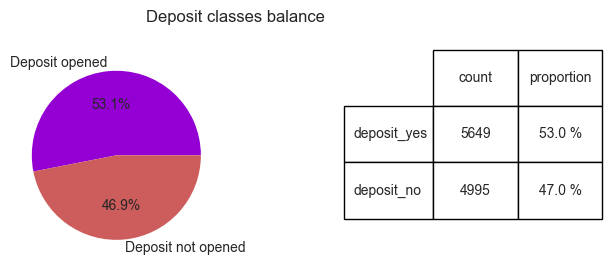

In [584]:
colors = cmap(np.linspace(0.3,0.5,2))

fig = plt.figure(figsize=(6,3))
plt.suptitle('Deposit classes balance')

ax = fig.add_subplot(1,2,1, facecolor='#ffffcb')

ax.pie( x=df['deposit'].value_counts(), autopct='%1.1f%%', colors=['darkviolet','indianred'], 
       labels=['Deposit opened', 'Deposit not opened'])
deposit_df = pd.concat(
    [df['deposit'].value_counts(),
     round(df['deposit'].value_counts(normalize=True)*100).astype(object).apply(lambda x: str(x)+' %')], axis=1).reset_index()

col_labels = list(deposit_df.drop('deposit', axis=1).columns)
row_labels = ['deposit_'+item for item in list(deposit_df['deposit'])[::-1]]
# colors = plt.cm.BuPu(np.linspace(0.3, 0.1, len(row_labels)))
colors_lst = np.empty(deposit_df[col_labels].shape, dtype=str)
colors_lst.fill('b')
dt = np.array(deposit_df[col_labels]).tolist()
ax.table(cellText = dt, cellLoc='center',
          rowLabels=row_labels, 
          colLabels=col_labels,
          bbox=[2,0.2,0.8,0.8]);

> * Целевой признак имеет 2 значения, возможно преобразование к бинарному.
> * Дисбаланс классов незначительный

#### Описание количественных признаков

In [585]:
# Выведем таблицу описания признаков
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10644.000000,10644.000000,10644.000000,10644.000000,10644.000000,10644.000000,10644.000000
mean,41.076381,1021.495678,15.640361,371.525554,2.504791,51.143743,0.825442
std,11.828645,1347.577934,8.430533,347.792521,2.672249,109.019894,2.275733
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,108.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,38.500000,497.000000,15.000000,254.000000,2.000000,-1.000000,0.000000
75%,49.000000,1440.250000,22.000000,495.000000,3.000000,6.500000,1.000000
max,95.000000,6422.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


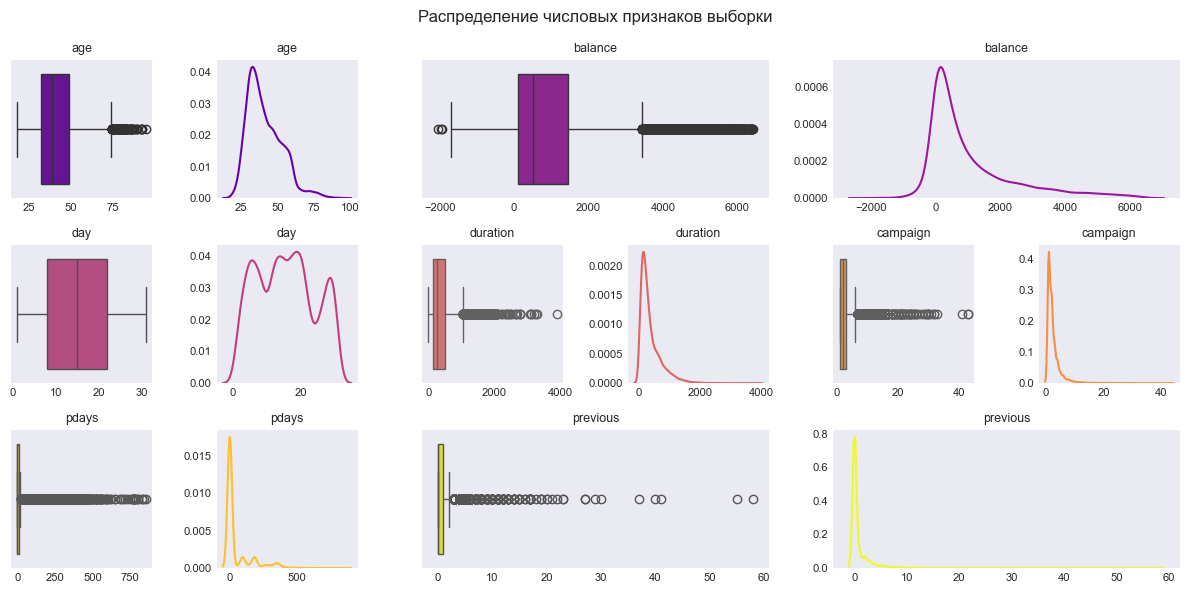

In [586]:
# Диаграммы распределения признаков
fig = plt.figure(figsize=(12,6))
colors = cmap(np.linspace(0.2,1,len(numeral_features)))
fig.suptitle('Распределение числовых признаков выборки')
i = 1
for feature, color in zip(numeral_features, colors):
    
    if feature == 'balance' or feature == 'previous':
        ax1 = fig.add_subplot(3,6,(i,i+1))
        sns.boxplot(df, x=feature, color=color, ax=ax1)
        ax2 = fig.add_subplot(3,6,(i+2,i+3))
        sns.kdeplot(df, x=feature, color=color, ax=ax2)
        i += 4
    else:
        ax1 = fig.add_subplot(3,6,i)
        sns.boxplot(df, x=feature, color=color, ax=ax1)
        ax2 = fig.add_subplot(3,6,i+1)
        sns.kdeplot(df, x=feature, color=color, ax=ax2)
        i += 2
    ax1.set_title(feature, fontsize=9)
    ax1.set_ylabel('')
    ax1.set_xlabel('')
    ax1.tick_params(labelsize=8)
    ax2.set_title(feature, fontsize=9)
    ax2.set_ylabel('')
    ax2.set_xlabel('')
    ax2.tick_params(labelsize=8)
fig.tight_layout()
fig.show();

> * Имеем большой разброс диапазонов данных (от 0 - 58 со средним 0.8 для признака 'previous' до -2049 до 6422 со средним 1021 для признака 'balance')
> * Признак 'day' имеет распределение, похожее на равномерное.
> * Остальные признаки имеют смещение распределения влево.
> * *Требуется нормализация непрерывных признаков*

#### Описание категориальных признаков

In [587]:
df[category_features].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10644,10644,10644,10644,10644,10644,10644,10644,10644
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2465,6039,5769,10477,5543,9212,7657,2733,7963


#### Исследование данных о клиентах

**Исследуем, в каком возрасте клиенты более склонны открывать депозит**

Процент клиентов с депозитом в возрастных группах младше 29 и старше 60 лет
deposit
yes    68.0
no     32.0
Name: proportion, dtype: float64
----------------------------------------
Процент клиентов с депозитом в возрастных группах от 29 до 60 лет
deposit
no     57.0
yes    43.0
Name: proportion, dtype: float64


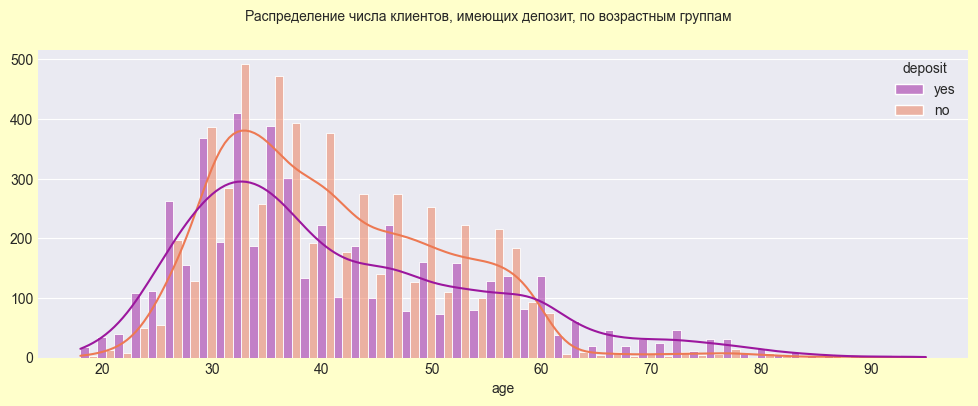

In [588]:
print('Процент клиентов с депозитом в возрастных группах младше 29 и старше 60 лет')
print((df[(df['age']<29)|(df['age']>60)]['deposit'].value_counts(normalize=True) * 100).round())
print('-'*40)
print('Процент клиентов с депозитом в возрастных группах от 29 до 60 лет')
print((df[(df['age']>=29)&(df['age']<=60)]['deposit'].value_counts(normalize=True, ascending=False) * 100).round())
fig = plt.figure(figsize=(12,4), facecolor='#ffffcb')
fig.suptitle('Распределение числа клиентов, имеющих депозит, по возрастным группам', fontsize=10)
hist1 = sns.histplot(df, x='age', hue='deposit', palette='plasma', kde=True, multiple='dodge', edgecolor='w')
plt.grid(visible=True, axis='y')
plt.ylabel('');

> * В возрастных категориях до 29 лет и старше 60 лет число клиентов с депозитом выше, чем число клиентов без депозита, причем, в возрасте до 25 лет и выше 65 лет более 50% клиентов имеют депозиты.
> * В возрасте от 29 до 60 лет число клиентов без депозита превышает число клиентов с депозитом примерно на 15%.

**Исследуем, клиенты с каким балансом более склонны открывать депозит**

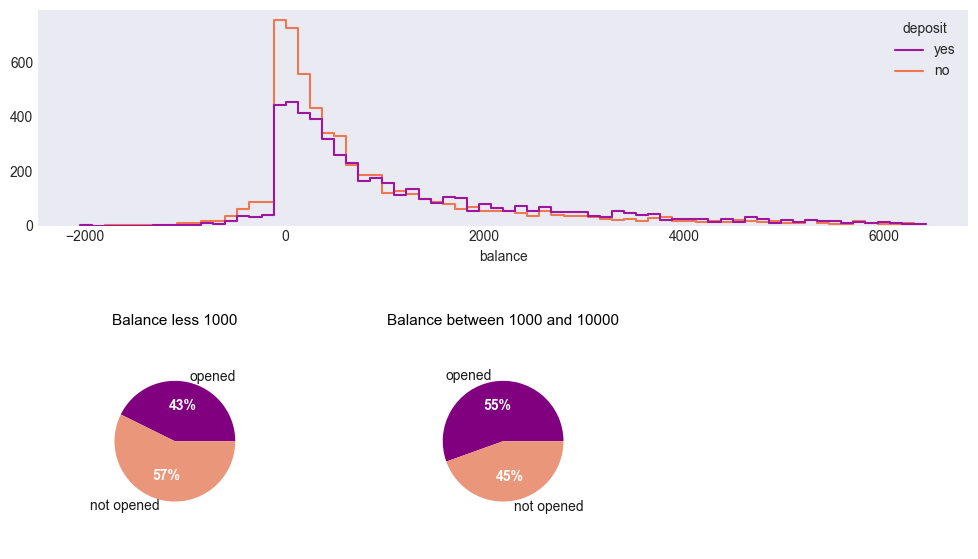

In [589]:
def deposit_pie(subplot, data, title):
     wedges, texts, autotexts = subplot.pie(data, 
                                            radius = 0.7, colors=['purple', 'darksalmon', 'darkslateblue','lightsteelblue'], 
                                            autopct='%1.0f%%', labels=['opened', 'not opened'], 
                                            textprops=dict(color='w', weight='bold'))
     subplot.set_title(title, fontdict={'color': 'black', 'size': 11})
     plt.setp(texts, color='#1A1A1A', weight='normal')   

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(2,3,(1,3))
sns.histplot(df, x='balance', hue='deposit', element="step", fill=False, palette='plasma', ax=ax1)
ax1.set_ylabel('')
deposit_pie(fig.add_subplot(2,3,4), 
            df[df['balance'] <=1000]['deposit'].value_counts().sort_index(ascending=False), 
            'Balance less 1000')
deposit_pie(fig.add_subplot(2,3,5), 
            df[(df['balance'] >1000)&(df['balance'] <10000)]['deposit'].value_counts().sort_index(ascending=False), 
            'Balance between 1000 and 10000')
# deposit_pie(fig.add_subplot(2,3,6), 
#             df[df['balance'] >= 10000]['deposit'].value_counts().sort_index(ascending=False), 
#             'Balance more than 10000')
plt.subplots_adjust(hspace=0.5)
plt.show();

> Клиенты с балансом выше 1000$ более склонны открывать депозит, разница между числом тех, кто открыл депозит и тех, кто не открыл депозит, составляет 10%.

**Исследуем, клиенты с каким уровнем образования более склонны открывать депозит**

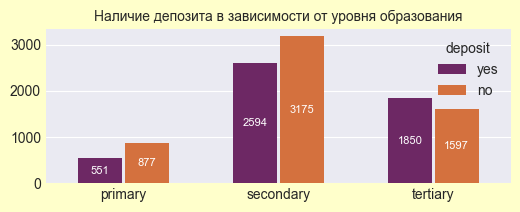

In [590]:
# Метки для диаграммы
fig = plt.figure(figsize=(6,2), facecolor='#ffffcb')
cp = sns.countplot(df, x='education', order=['primary', 'secondary', 'tertiary'], 
                   hue='deposit', palette='inferno', width=0.6, gap=0.05)
plt.grid(visible=True, axis='y')
plt.title('Наличие депозита в зависимости от уровня образования', fontdict={'size':10})
plt.xlabel('')
plt.ylabel('')
cp.bar_label(cp.containers[0], fontsize=8, label_type='center', color='w')
cp.bar_label(cp.containers[1], fontsize=8, label_type='center', color='w');

> * Более склонны открывать депозит клиенты с высшим образованием (разница составляет 253 человека или 8%)
> * Наиболее многочисленна группа клиентов, имеющих среднее образование. Среди них число тех, у кого нет депозита, превышает число клиентов с депозитом (разница составляет 581 человек или 10%)
> * Среди клиентов, имеющих начальное образование (самая малочисленная группа), разница между открывшими депозит и не имеющими депозит наибольшая (число тех, кто не открыл депозит на 326 человек или на 22% больше, чем тех, кто имеет депозит)

**Зависимость наличия депозита от позиции на работе**

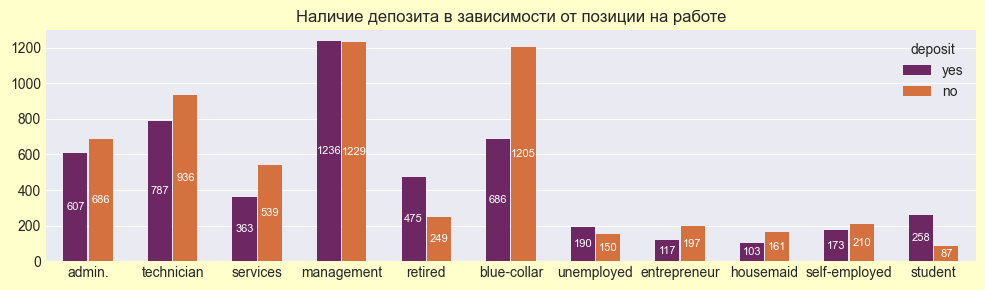

In [591]:
fig = plt.figure(figsize=(12,3), facecolor='#ffffcb')
cp = sns.countplot(df, x='job', hue='deposit', palette='inferno', width=0.6, gap=0.05)
plt.grid(visible=True, axis='y')
plt.title('Наличие депозита в зависимости от позиции на работе')
plt.xlabel('')
plt.ylabel('')
cp.bar_label(cp.containers[0], fontsize=8, label_type='center', color='w')
cp.bar_label(cp.containers[1], fontsize=8, label_type='center', color='w');


> * Превышение числа клиентов, открывших депозит, наблюдается в группах "retired" (пенсионеры), "unemployed" (безработные) и "students" (студенты). Причем, количество студентов с депозитом вдвое превышает число студентов без депозита(скорее всего, депозиты на образование, открытые и собираемые ранее).
> * В 'management' (управляющий персонал) число людей с депозитом и без депозита распределено почти пополам.
> * Наименьший относительный процент открытия депозитов в группе "blue_collar" (рабочая специальность). Число клиентов с депозитом почти в два раза ниже, чем число клиентов без депозита.
> * В остальных группах чило клиентов без депозита больше, чем число клиентов с депозитом.

**Зависимость наличия депозита от семейного положения**

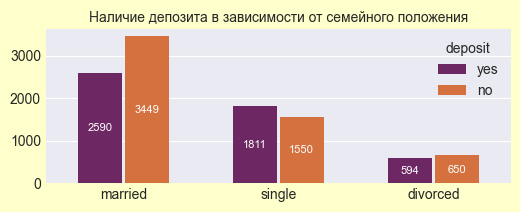

In [592]:
fig = plt.figure(figsize=(6,2), facecolor='#ffffcb')
cp = sns.countplot(df, x='marital', hue='deposit', palette='inferno', width=0.6, gap=0.05)
plt.grid(visible=True, axis='y')
plt.title('Наличие депозита в зависимости от семейного положения', fontdict={'size':10})
plt.xlabel('')
plt.ylabel('')
cp.bar_label(cp.containers[0], fontsize=8, label_type='center', color='w')
cp.bar_label(cp.containers[1], fontsize=8, label_type='center', color='w');

> * У разведенных клиентов группы с депозитом и без разделяются приблизительно пополам.
> * Семейных клиентов, имеющих депозит, примерно на 20% меньше, чем не имеющих депозит (2590 против 3449). 
> * У клиентов без семьи наличие депозита встречается примерно на 10% чаще (1811 против 1550).

**Зависимость открытия депозита от наличия кредита**

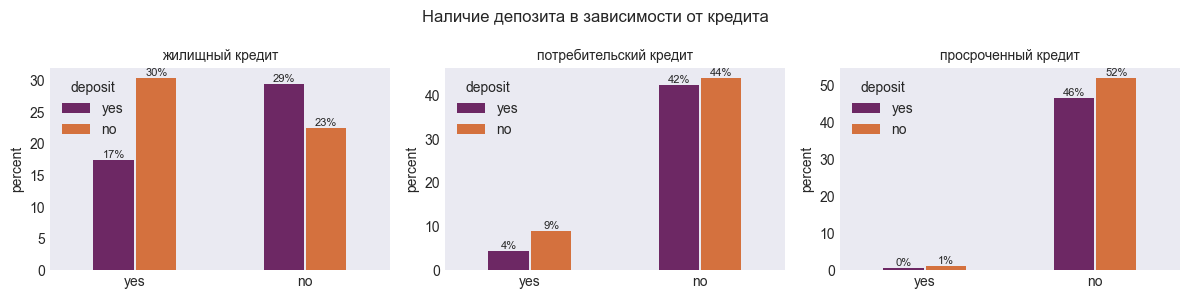

In [593]:
fig = plt.figure(figsize=(12,3))
fig.suptitle('Наличие депозита в зависимости от кредита')

def add_plot(data, feature, subplot, title):
    ax = plt.subplot(1,3,subplot)
    sns.countplot(data, x=feature, order = ['yes', 'no'], 
                  hue='deposit', stat='percent',
                  palette='inferno', width=0.5, gap=0.05, ax=ax)
    ax.set_title(title, fontdict={'size': 10})
    ax.set_xlabel('')
    ax.bar_label(ax.containers[0], fontsize=8, fmt='%.0f%%')
    ax.bar_label(ax.containers[1], fontsize=8, fmt='%.0f%%');

features = ['housing', 'loan', 'default']
titles = ['жилищный кредит', 'потребительский кредит','просроченный кредит']    
for i, feature, title in zip(range(1,4), features, titles):
    add_plot(df, feature, i, title)
fig.tight_layout();


> Результаты исследования данных о клиентах:
> * Более склонны открывать депозит клиенты моложе 30 лет и старше 60 лет.
> * Клиенты с высоким балансом более склонны открывать депозит.
> * Более склонны открывать депозит люди с высшим образованием.
> * Наименьший относительный процент открытия депозитов в группе "blue_collar".
> * Превышение числа клиентов, открывших депозит, наблюдается в группах "management", "retired", "unemployed" и "students" (для последних это, скорее всего, депозиты на образование, открытые и собираемые ранее)
> * Чаще открывают депозит клиенты, у которых нет семьи.
> * Более склонны открывать депозит клиенты, у которых нет кредитов.

#### Исследование данных о маркетинговой кампании

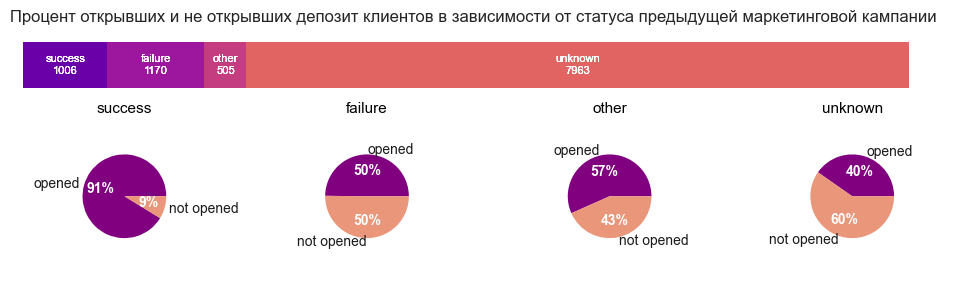

In [594]:
# Для какого статуса предыдущей маркетинговой кампании 
# успех в текущей превалирует над количеством неудач.
poutcome_deposit = df.pivot_table(index='deposit', 
                                  columns='poutcome', 
                                  values='age', 
                                  aggfunc='count').reset_index().sort_values('deposit', 
                                                                             ascending=False)
fig = plt.figure(figsize=(12,3))
fig.suptitle('Процент открывших и не открывших депозит клиентов в зависимости от статуса предыдущей маркетинговой кампании')

ax = fig.add_subplot(4,4,(1,4), facecolor='w')
df_copy = df['poutcome'].value_counts().to_dict()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
left = np.zeros(4)
x=0
for poutcome, color in zip(['success', 'failure', 'other', 'unknown'], colors):
    length = df_copy[poutcome]
    ax = plt.barh(x, length, height=0.001, label=poutcome, color=color, left=left)
    plt.bar_label(ax, label_type='center', fmt=lambda x: f'{poutcome}\n{x:.0f}', fontsize=8, color='w')
    left += length

for i, item in enumerate(['success', 'failure', 'other', 'unknown']):
    ax = fig.add_subplot(3,4,(i+5, i+9))
    deposit_pie(ax, poutcome_deposit[item], item)

plt.show();

> * Результат проведения предыдущей маркетинговой кампании известен для примерно 20% клиентов банка, из них с 1006 клиентами контакт прошел успешно, 1170 клиентов не откликнулись на кампанию. Результат кампании для почти 80% клиентов неизвестен.
> * Среди клиентов, контакт с которыми в маркетинговой кампании был успешен, 91% открыли депозит.
> * Среди клиентов, с которыми не был установлен контакт в маркетинговую кампанию, 50% открыли депозит.
> * Среди клиентов, результат общения с которыми неизвестен, открыли депозит 40%.

**Распределение числа согласий и отказов открыть депозит по месяцам**

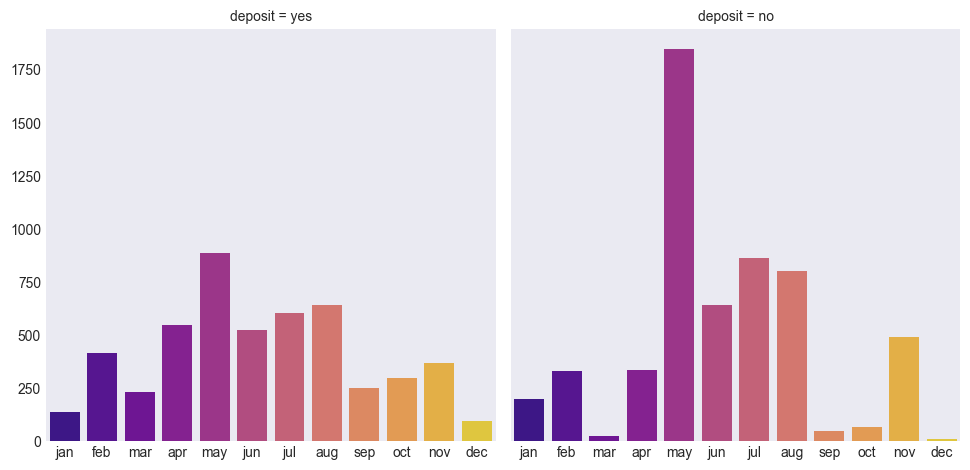

In [595]:
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
ax = sns.catplot(df, x='month', kind='count', col='deposit', order=months, palette='plasma')
ax.set_xlabels('')
ax.set_ylabels('')
plt.show()

> * Наибольшее число отказов открыть депозит, как и наибольшее число согласий приходится на май. Однако, в этом месяце число отказов более чем в 2 раза превысило число согласий.

### Преобразование данных

In [596]:
df_copy = df.copy()

#### Порядковое кодирование признака 'education'

**Кодирование признака 'education' методом LabelEncoding**

In [597]:
# Кодирование LabelEncoding
encoder = preprocessing.LabelEncoder()
data_encoded = encoder.fit_transform(pd.DataFrame(df['education']))
df['education'] = data_encoded

**Бинарное кодирование признаков 'default','housing', 'loan', 'deposit'**

In [598]:
# преобразуйте бинарные переменные в представление из нулей и единиц
def bin_feature_encoding(data, feature):
    encoder = preprocessing.LabelEncoder()
    data[feature] = encoder.fit_transform(data[feature])
    
features_bin = ['default','housing', 'loan', 'deposit']
for feature in features_bin:
    bin_feature_encoding(df, feature)
    
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1


**Кодирование остальных категориальных признаков**

In [599]:
features = list(df.select_dtypes('object')) # Список факторов для кодирования

features_encoded = pd.get_dummies(df[features]) # Кодируем признаки
df = pd.concat([df,features_encoded], axis=1) # Добавляем закодированные признаки в таблицу

# Удаляем закодированные признаки
df.drop(columns = features, inplace=True)
df.shape

(10644, 45)

####  Исследование мультиколлинеарности признаков

**Корреляция целевого признака с факторами**

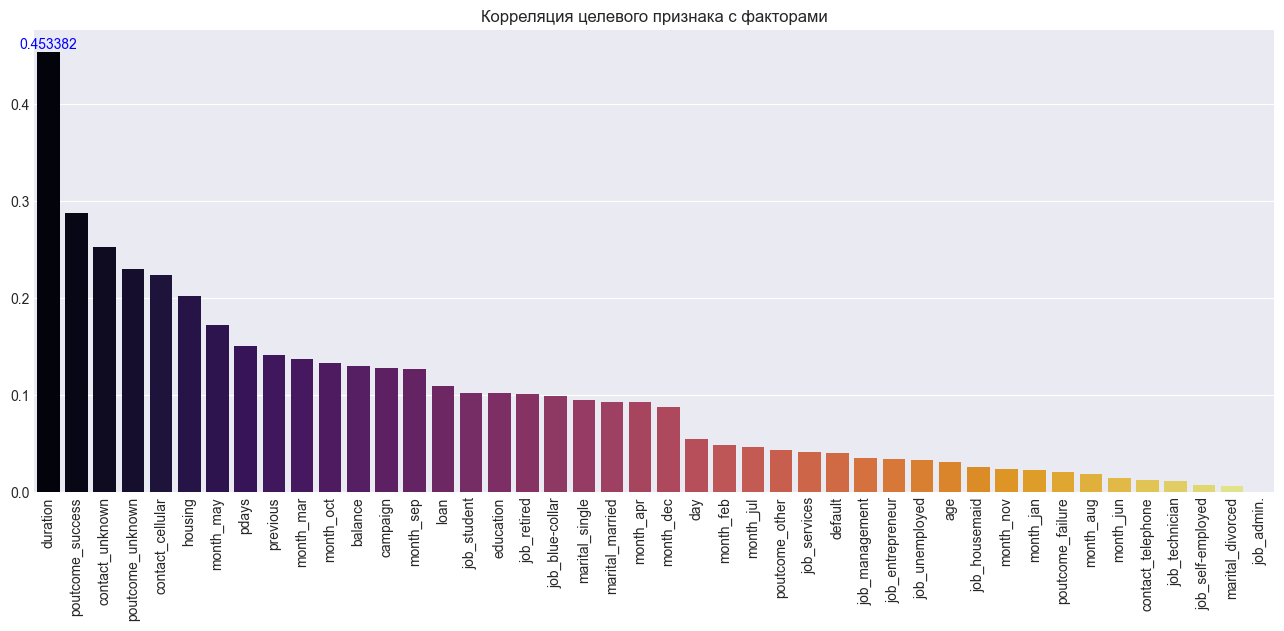

In [600]:
# корреляция целевого признака с факторами
fig = plt.figure(figsize=(16,6))

bp = sns.barplot(df.corr()['deposit'].abs().drop(columns='deposit').sort_values(ascending=False).drop('deposit', axis=0),
                 palette='inferno')
plt.ylabel('')
plt.grid(True, axis='y')
plt.xticks(rotation=90, fontsize=10)
bp.set_title('Корреляция целевого признака с факторами', fontsize=12)
bp.bar_label(bp.containers[0], color='b')
plt.show();


> * Сильной корреляции с целевым признаком нет ни у одного фактора.
> * Наибольшую корреляцию имеет фактор 'duration' (приблизительно 0.46).

**Корреляция признаков между собой**

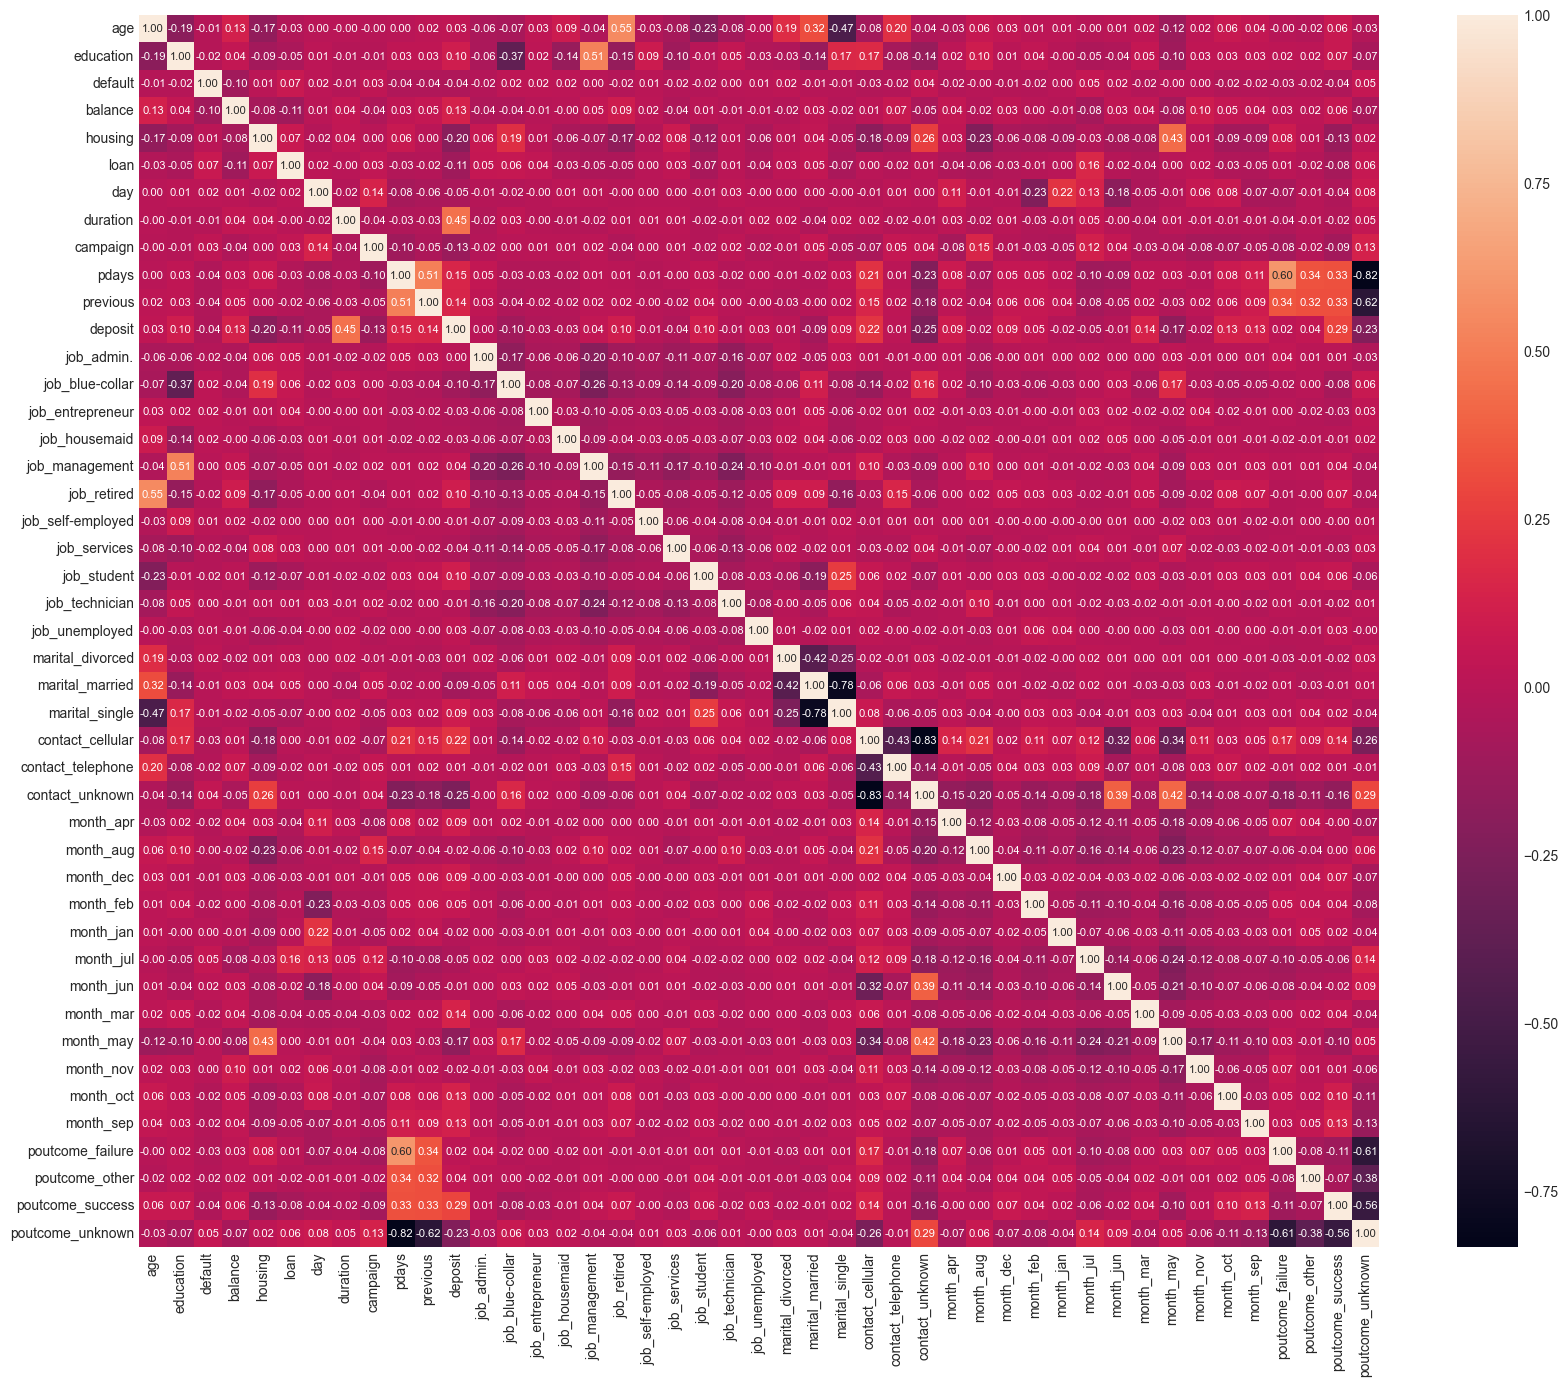

In [601]:
fig = plt.figure(figsize=(20,16))
sns.heatmap(df.corr(), annot=True, annot_kws={'size':8}, fmt='.2f');

> * Сильная обратная корреляция признаков pdays и poutcome_unknown (-0.82)
> * Сильная обратная корреляция признаков contact_cellular и contact_unknown (-0.83)
> * Близкая к сильной корреляция призаков marital_maried и marital_single (-0.78)

In [602]:
# Удалим признаки с высокой корреляцией
df.drop(columns=['poutcome_unknown', 'contact_unknown'], inplace=True)

#### Подготовка выборок

In [603]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print(f'X_train shape: {X_train.shape}          X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}             y_test shape: {y_test.shape}')

X_train shape: (7131, 42)          X_test shape: (3513, 42)
y_train shape: (7131,)             y_test shape: (3513,)


#### Отбор наиболее значимых признаков

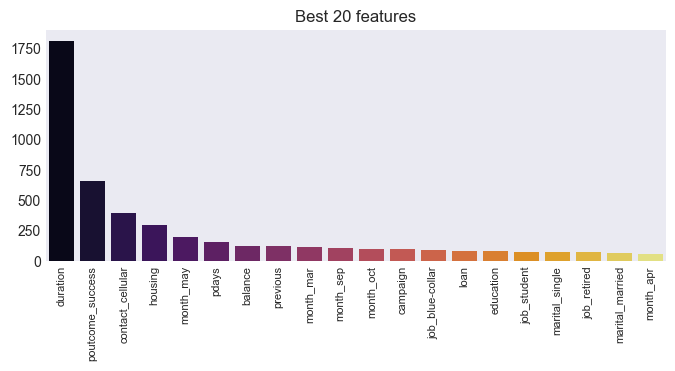

In [604]:
# с помощью SelectKBest отберем  20 наиболее подходящих признаков
SKB_model = SelectKBest(k=20)
SKB_model.fit(X_train, y_train)
best_features  = list(SKB_model.get_feature_names_out())
best_features.sort()
best_features_score = pd.Series(data=SKB_model.scores_, index=SKB_model.feature_names_in_).loc[best_features].sort_values(ascending=False)

# Best Features barplot

fig = plt.figure(figsize=(8,3))
bp = sns.barplot(x=best_features_score.index, y=best_features_score.values, palette='inferno')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('')
plt.title('Best 20 features')
plt.show;

#### Нормализация данных

In [605]:
# Процедура вывода распределения числовых признаков
def features_kdeplot(data, features, title):  
    fig = plt.figure(figsize=(12,3))
    fig.suptitle(title, fontsize=10)
    for i, feature in enumerate(features):
        ax = fig.add_subplot(2,6,i+1)
        sns.kdeplot(data, x=feature, ax=ax)
        ax.set_title(feature, fontdict={'size': 8})
        ax.set_xlabel('')
        ax.axes.tick_params(labelsize=8)
        ax.set_ylabel('')
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show();

Исследуем распределение числовых признаков

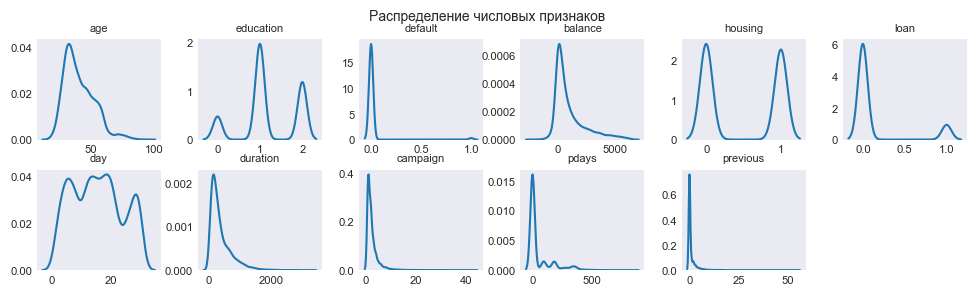

In [606]:
# Создадим список числовых признаков
features = list(X.select_dtypes(['int', 'float']).columns) # Список признаков

# Выведем распределение признаков
features_kdeplot(X_train, features, 'Рaспределение числовых признаков')

> Распределения признаков не являются нормальными, есть выбросы. Для стандартизации признаков применим MinMaxScaler и RobustScaler. Сравним результаты.

In [607]:
# Нормализуем данные данные с помощью MinMaxScaler
scaler = preprocessing.MinMaxScaler()
X_train_scaled_mm = scaler.fit_transform(X_train)
X_test_scaled_mm = scaler.transform(X_test)

scaler_20 = preprocessing.MinMaxScaler()
X_train_scaled_mm_20 = scaler_20.fit_transform(X_train[best_features])
X_test_scaled_mm_20 = scaler_20.transform(X_test[best_features])

In [608]:
# Нормализуем данные данные с помощью RobustScaler
scaler = preprocessing.RobustScaler()
X_train_scaled_r = scaler.fit_transform(X_train)
X_test_scaled_r = scaler.transform(X_test)

scaler_20 = preprocessing.RobustScaler()
X_train_scaled_r_20 = scaler_20.fit_transform(X_train[best_features])
X_test_scaled_r_20 = scaler_20.transform(X_test[best_features])

Построим графики распределений после стандартизации

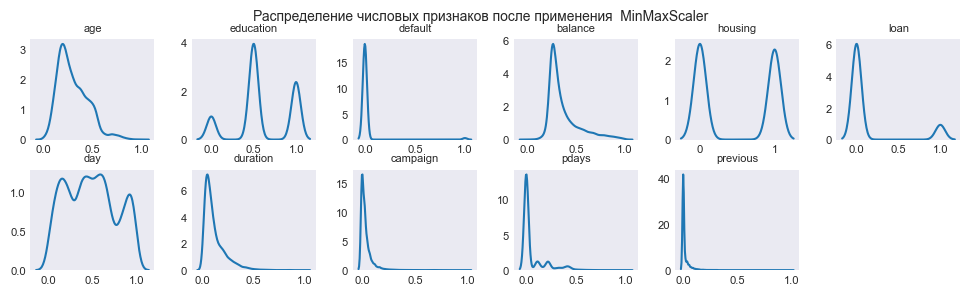

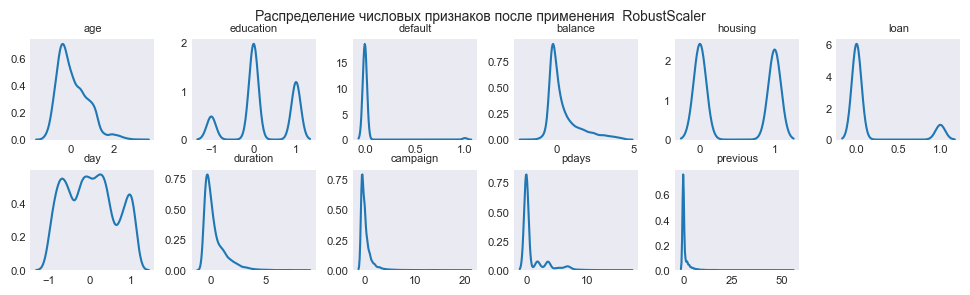

In [609]:
features_kdeplot(pd.DataFrame(X_train_scaled_mm, columns=scaler.feature_names_in_), features,
                 'Распределение числовых признаков после применения  MinMaxScaler')   
features_kdeplot(pd.DataFrame(X_train_scaled_r, columns=scaler.feature_names_in_), features,
                 'Распределение числовых признаков после применения  RobustScaler')   

> Датасет подготовлен, переходим к решению задачи классификации

### Решение задачи классификации

In [610]:
# Процедура обучения модели  и вывода метрик
def model_learning_metrics(model, X_train, y_train, X_test, y_test, model_metrics, scaler='MinMaxScaler'):
    
    model_params=''
    model.fit(X_train, y_train) # обучение модели

    y_train_pred = model.predict(X_train) # предсказание на обучающей выборке
    y_test_pred = model.predict(X_test) # предсказание на тестовой выборке

    print('Метрики обучающей выборки\n',metrics.classification_report(y_train, y_train_pred))
    print('Метрики тестовой выборки\n',metrics.classification_report(y_test, y_test_pred))
        
    if type(model) == tree.DecisionTreeClassifier:
        model_params = ' ' + ' '.join([str(model.get_depth()),
                                       str(model.get_params()['min_samples_leaf']),
                                       str(model.get_params()['min_samples_split'])])
        print('-'*40, '\nГлубина дерева:', model.get_depth())
        print('Минимальное число объектов листа:', model.get_params()['min_samples_leaf'])
        print('Минимальное число объектов для деления листа:', model.get_params()['min_samples_split'])
        print('-'*40)
    
    if type(model) == ensemble.RandomForestClassifier:
        model_params = ' ' + ' '.join([str(model.get_params()['n_estimators']),
                                        str(model.get_params()['max_depth']),
                                        str(model.get_params()['min_samples_leaf']),
                                        str(model.get_params()['min_samples_split'])])
        print('-'*40, '\nЧисло деревьев:', model.get_params()['n_estimators'])
        print('Глубина дерева:', model.get_params()['max_depth'])
        print('Минимальное число объектов листа:', model.get_params()['min_samples_leaf'])
        print('Минимальное число объектов для деления листа:', model.get_params()['min_samples_split'])
        print('-'*40)
    
    #Вычисление и запись метрик
    model_type = str(type(model))[8:][:-2].split('.')[-1] + model_params
    model_metrics = pd.concat([model_metrics, pd.DataFrame({
            'model': [model_type],
            'scaler': [scaler],
            'n_features': [model.n_features_in_],
            'acc_train': [round(metrics.accuracy_score(y_train, y_train_pred),2)],
            'acc_test': [round(metrics.accuracy_score(y_test, y_test_pred),2)],
            'f1_train': [round(float(metrics.f1_score(y_train, y_train_pred)),2)],
            'f1_test': [round(float(metrics.f1_score(y_test, y_test_pred)),2)]
            })], axis=0)
    return model_metrics

# Процедура создания списка уровня значимости признаков
def get_feature_scores(model):
    feature_scores = pd.Series(data = model.feature_importances_, index = model.feature_names_in_).sort_values(ascending=False)
    best_fs = list(feature_scores.index)[:20]
    best_fs.sort()
    print('20 наиболее значимых признаков:\n', best_fs)
    return feature_scores

In [611]:
# Создаем таблицу метрик
model_metrics = pd.DataFrame(columns=['model', 'scaler', 'n_features', 
                                      'acc_train', 'acc_test', 'f1_train', 'f1_test'])

#### Метод логистической регрессии

#### Выборка, нормализованная MinMaxScaler

##### Предсказание по всем признакам

In [612]:
%%time
model = linear_model.LogisticRegression(solver='sag',
                                           max_iter=1000,
                                           verbose=10,
                                           n_jobs=-1, 
                                           random_state=42)

model_metrics = model_learning_metrics(model, 
                                          X_train_scaled_mm, y_train, 
                                          X_test_scaled_mm, y_test, 
                                          model_metrics)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 26 epochs took 0 seconds
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      3785
           1       0.83      0.79      0.81      3346

    accuracy                           0.83      7131
   macro avg       0.83      0.82      0.82      7131
weighted avg       0.83      0.83      0.83      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.82      0.87      0.85      1864
           1       0.85      0.78      0.81      1649

    accuracy                           0.83      3513
   macro avg       0.83      0.83      0.83      3513
weighted avg       0.83      0.83      0.83      3513

CPU times: total: 250 ms
Wall time: 259 ms


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s


##### Предсказание по 20 наиболее значимым признакам

In [613]:
%%time
model = linear_model.LogisticRegression(solver='sag',
                                           max_iter=1000,
                                           verbose=10,
                                           n_jobs=-1, 
                                           random_state=42)

model_metrics = model_learning_metrics(model, 
                                          X_train_scaled_mm_20, y_train, 
                                          X_test_scaled_mm_20, y_test, 
                                          model_metrics)

convergence after 21 epochs took 0 seconds

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s



Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      3785
           1       0.83      0.76      0.80      3346

    accuracy                           0.82      7131
   macro avg       0.82      0.81      0.81      7131
weighted avg       0.82      0.82      0.82      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.81      0.87      0.84      1864
           1       0.84      0.76      0.80      1649

    accuracy                           0.82      3513
   macro avg       0.82      0.82      0.82      3513
weighted avg       0.82      0.82      0.82      3513

CPU times: total: 141 ms
Wall time: 169 ms


#### Выборка, нормализованная RobustScaler

##### Предсказание по всем признакам

In [614]:
%%time
model = linear_model.LogisticRegression(solver='sag',
                                           max_iter=1000,
                                           verbose=10,
                                           n_jobs=-1, 
                                           random_state=42)

model_metrics = model_learning_metrics(model, 
                                       X_train_scaled_r, y_train, 
                                       X_test_scaled_r, y_test, 
                                       model_metrics, scaler='RobustScaler')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 321 epochs took 2 seconds
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      3785
           1       0.83      0.80      0.81      3346

    accuracy                           0.83      7131
   macro avg       0.83      0.83      0.83      7131
weighted avg       0.83      0.83      0.83      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.83      0.86      0.84      1864
           1       0.84      0.79      0.82      1649

    accuracy                           0.83      3513
   macro avg       0.83      0.83      0.83      3513
weighted avg       0.83      0.83      0.83      3513

CPU times: total: 2.14 s
Wall time: 2.28 s


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s


##### Предсказание по 20 наиболее значимым признакам

In [615]:
%%time
model = linear_model.LogisticRegression(solver='sag',
                                           max_iter=1000,
                                           verbose=10,
                                           n_jobs=-1, 
                                           random_state=42)

model_metrics = model_learning_metrics(model, 
                                       X_train_scaled_r_20, y_train, 
                                       X_test_scaled_r_20, y_test, 
                                       model_metrics, scaler='RobustScaler')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 250 epochs took 0 seconds
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.81      0.86      0.84      3785
           1       0.83      0.78      0.80      3346

    accuracy                           0.82      7131
   macro avg       0.82      0.82      0.82      7131
weighted avg       0.82      0.82      0.82      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.81      0.86      0.84      1864
           1       0.83      0.78      0.80      1649

    accuracy                           0.82      3513
   macro avg       0.82      0.82      0.82      3513
weighted avg       0.82      0.82      0.82      3513

CPU times: total: 844 ms
Wall time: 854 ms


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s


##### Вывод метрик по построенным моделям классификации

In [616]:
model_metrics

,model,scaler,n_features,acc_train,acc_test,f1_train,f1_test
0,LogisticRegression,MinMaxScaler,42,0.83,0.83,0.81,0.81
0,LogisticRegression,MinMaxScaler,20,0.82,0.82,0.80,0.80
0,LogisticRegression,RobustScaler,42,0.83,0.83,0.81,0.82
0,LogisticRegression,RobustScaler,20,0.82,0.82,0.80,0.80


> Предсказание имеет точность около 80%, переобученность моделей не наблюдается, разницы в метриках при разных методах стандартизации, а также при обучении на полном наборе признаков или на наборе 20 наиболее значимых признаков также не наблюдается.

#### Дерево решений

##### Предсказание на полном наборе данных

In [617]:
tree_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
%time model_metrics = model_learning_metrics(tree_model, X_train, y_train, X_test, y_test, model_metrics, 'not scaled')
tree_feature_score = get_feature_scores(tree_model) # сохраним уровни значимости признаков
print('20 наиболее значимых признаков:\n', best_features)

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3785
           1       1.00      1.00      1.00      3346

    accuracy                           1.00      7131
   macro avg       1.00      1.00      1.00      7131
weighted avg       1.00      1.00      1.00      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      1864
           1       0.80      0.75      0.77      1649

    accuracy                           0.79      3513
   macro avg       0.79      0.79      0.79      3513
weighted avg       0.79      0.79      0.79      3513

---------------------------------------- 
Глубина дерева: 31
Минимальное число объектов листа: 1
Минимальное число объектов для деления листа: 2
----------------------------------------
CPU times: total: 203 ms
Wall time: 198 ms
20 наиболее значимых признаков:
 ['age', 'balance', 'campaign', 

> Списки наиболее значимых признаков, отобранных процедурой и признаков дерева решений не совпадают

##### Предсказание на 20 наиболее значимых признаках

In [618]:
%%time
tree_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
model_metrics = model_learning_metrics(tree_model, X_train[best_features], y_train, X_test[best_features], y_test, model_metrics, 'not scaled')

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3785
           1       1.00      1.00      1.00      3346

    accuracy                           1.00      7131
   macro avg       1.00      1.00      1.00      7131
weighted avg       1.00      1.00      1.00      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.77      0.79      0.78      1864
           1       0.75      0.73      0.74      1649

    accuracy                           0.76      3513
   macro avg       0.76      0.76      0.76      3513
weighted avg       0.76      0.76      0.76      3513

---------------------------------------- 
Глубина дерева: 36
Минимальное число объектов листа: 1
Минимальное число объектов для деления листа: 2
----------------------------------------
CPU times: total: 156 ms
Wall time: 158 ms


In [619]:
tree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

> Наблюдается явная переобученность дерева решений, построенного как на полном наборе даных, так и на 20 отобранных признаках.

#### Подбор гиперпараметров для дерева решений (метод GridSearch)

In [620]:
# Процедура подбора гиперпараметров и построения кривых Accuracy
def DT_hyperparameters(X_train, y_train, X_test, y_test, param_space, model_metrics, scaler='not scaled'):

        # Запуск процедуры подбора параметров
        grid_search = GridSearchCV(estimator = tree.DecisionTreeClassifier(),
                                param_grid=param_space,
                                return_train_score = True,
                                scoring = 'accuracy',
                                cv=5,
                                verbose=10,
                                n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Предсказание на основании выбранных гиперпараметров
        y_train_pred = grid_search.predict(X_train) # обучающая выборка
        y_test_pred = grid_search.predict(X_test) # тестовая выборка

        #Вычисление и запись метрик
        model_metrics = pd.concat([model_metrics, pd.DataFrame({
                'model': [' '.join(['DesicionTreeClassifier'] + list(map(str, grid_search.best_params_.values())))],
                'scaler': [scaler],
                'n_features': [X_train.shape[1]],
                'acc_train': [round(metrics.accuracy_score(y_train, y_train_pred),3)],
                'acc_test': [round(metrics.accuracy_score(y_test, y_test_pred),3)],
                'f1_train': [round(float(metrics.f1_score(y_train, y_train_pred)),3)],
                'f1_test': [round(float(metrics.f1_score(y_test, y_test_pred)),3)]
                })], axis=0)

        print('Метрики обучающей выборки\n',metrics.classification_report(y_train, y_train_pred))
        print('Метрики тестовой выборки\n',metrics.classification_report(y_test, y_test_pred))
        print('-'*40, '\n', grid_search.best_params_)
        
        # Построение кривых Accuracy в зависимости от глубины дерева
        fig = plt.figure(figsize=(10,3))
        fig.suptitle('Кривые зависимости метрики Accuracy от глубины дерева')
        line1 = sns.lineplot(x=grid_search.cv_results_['param_max_depth'], 
                y=grid_search.cv_results_['mean_train_score'], label='train score')
        line2 = sns.lineplot(x=grid_search.cv_results_['param_max_depth'], 
                y=grid_search.cv_results_['mean_test_score'], color='maroon', label='test score')
        plt.scatter(x=[grid_search.best_params_['max_depth']],
                y=[grid_search.best_score_], color='green')
        plt.xticks(grid_search.cv_results_['param_max_depth'])
        plt.yticks(np.linspace(0.75,1,10).round(2).tolist())
        plt.grid()
        plt.legend(loc='upper left');
        
        return grid_search, model_metrics


##### Построение модели на всех признаках

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.91      0.84      0.88      3785
           1       0.84      0.91      0.87      3346

    accuracy                           0.87      7131
   macro avg       0.88      0.88      0.87      7131
weighted avg       0.88      0.87      0.87      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.84      0.79      0.82      1864
           1       0.78      0.83      0.80      1649

    accuracy                           0.81      3513
   macro avg       0.81      0.81      0.81      3513
weighted avg       0.81      0.81      0.81      3513

---------------------------------------- 
 {'max_depth': 10, 'min_samples_split': 10}
CPU times: total: 5.75 s
Wall time: 28.9 s
20 наиболее значимых признаков:
 ['age', 'balance', 'campaign', 'contact_cellular', 'contact_telephon

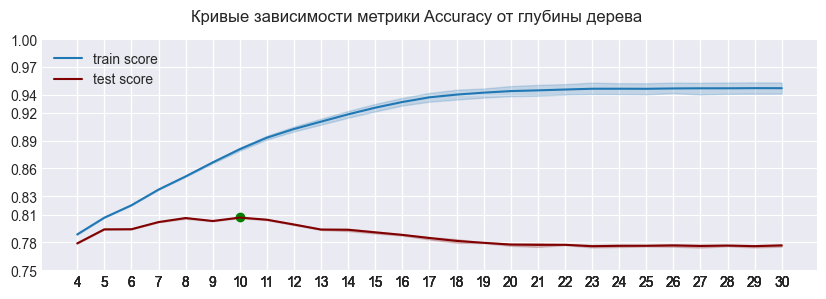

In [621]:
# Задаем пространство гиперпараметров
param_space = {'max_depth': np.linspace(4,30,27).astype('int').tolist(),
               'min_samples_split': [7, 8, 9, 10, 11]}
 
# Запускаем процедуру подбора параметров
%time grid_search, model_metrics = DT_hyperparameters(X_train, y_train, X_test, y_test, param_space, model_metrics)

tree_best_feature_score = get_feature_scores(grid_search.best_estimator_) # сохраним уровни значимости признаков
print('20 наиболее значимых признаков:\n', best_features)

##### Построение модели на 20 отобранных признаках

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.89      0.86      0.88      3785
           1       0.85      0.88      0.87      3346

    accuracy                           0.87      7131
   macro avg       0.87      0.87      0.87      7131
weighted avg       0.87      0.87      0.87      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1864
           1       0.79      0.80      0.80      1649

    accuracy                           0.81      3513
   macro avg       0.81      0.81      0.81      3513
weighted avg       0.81      0.81      0.81      3513

---------------------------------------- 
 {'max_depth': 10, 'min_samples_split': 7}
CPU times: total: 4.91 s
Wall time: 18.6 s


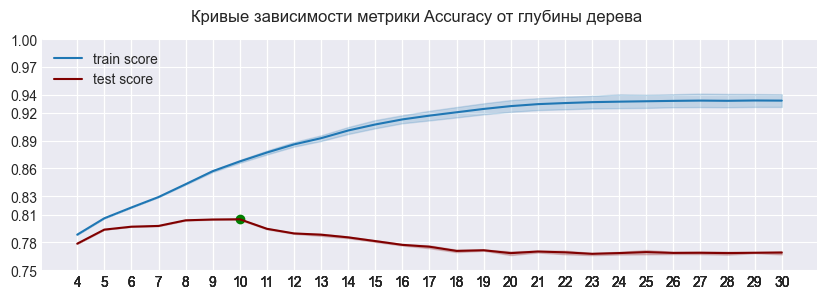

In [622]:
# Запускаем процедуру подбора параметров
%time grid_search, model_metrics = DT_hyperparameters(X_train[best_features], y_train, X_test[best_features], y_test, param_space, model_metrics)

> * Дерево решений с подобранным набором параметров все равно дает переобученность модели (F1-score для класса 1 равно 0.86 на обучающей и 0.79 на тестовой выборках).
> * При построении модели на полном наборе признаков список наиболее значимых признаков не совпадает с отобранными ранее признаками

### Ансамбли моделей и построение прогноза

#### Случайный лес
**Построение модели на всех признаках**

In [623]:
# Обучение модели случайного леса
forest_model = ensemble.RandomForestClassifier(n_estimators = 100,
                                               criterion = 'gini',
                                               min_samples_leaf = 5,
                                               max_depth = 10,
                                               random_state = 42)

model_metrics = model_learning_metrics(forest_model, X_train, y_train, X_test, y_test, model_metrics, 'not scaled')
forest_feature_score = get_feature_scores(forest_model)
print('20 наиболее значимых признаков:\n', best_features)

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      3785
           1       0.84      0.88      0.86      3346

    accuracy                           0.87      7131
   macro avg       0.87      0.87      0.87      7131
weighted avg       0.87      0.87      0.87      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      1864
           1       0.82      0.86      0.84      1649

    accuracy                           0.85      3513
   macro avg       0.85      0.85      0.85      3513
weighted avg       0.85      0.85      0.85      3513

---------------------------------------- 
Число деревьев: 100
Глубина дерева: 10
Минимальное число объектов листа: 5
Минимальное число объектов для деления листа: 2
----------------------------------------
20 наиболее значимых признаков:
 ['age', 'balance', 'campaign', 'contact_cellular', 'da

**Построение модели на 20 отобранных признаках**

In [624]:
# Обучение модели случайного леса
forest_model = ensemble.RandomForestClassifier(n_estimators = 100,
                                               criterion = 'gini',
                                               min_samples_leaf = 5,
                                               max_depth = 10,
                                               random_state = 42)

model_metrics = model_learning_metrics(forest_model, 
                                       X_train[best_features], y_train, 
                                       X_test[best_features], y_test, 
                                       model_metrics, 'not scaled')

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      3785
           1       0.83      0.87      0.85      3346

    accuracy                           0.86      7131
   macro avg       0.86      0.86      0.86      7131
weighted avg       0.86      0.86      0.86      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1864
           1       0.82      0.84      0.83      1649

    accuracy                           0.84      3513
   macro avg       0.84      0.84      0.84      3513
weighted avg       0.84      0.84      0.84      3513

---------------------------------------- 
Число деревьев: 100
Глубина дерева: 10
Минимальное число объектов листа: 5
Минимальное число объектов для деления листа: 2
----------------------------------------


##### Подбор гиперпараметров случайного леса методом Optuna

**Построение модели на всех признаках**

In [625]:
# Процедура вычисления случайного леса на пространстве гиперпараметров
def optuna_rf(trial):
    # Задаем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          verbose=1,
                                          random_state=42)
    # Обучаем модель
    model.fit(X_train, y_train)
    # Вычисляем метрику
    r1 = metrics.f1_score(y_train, model.predict(X_train))
    return r1

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
%time study.optimize(optuna_rf, n_trials=20)

[I 2025-05-11 19:23:44,890] A new study created in memory with name: RandomForestClassifier
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[I 2025-05-11 19:23:46,743] Trial 0 finished with value: 0.882259691598213 and parameters: {'n_estimators': 150, 'max_depth': 28, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.882259691598213.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[I 2025-05-11 19:23:49,688] Trial 1 finished with value: 0.8942615787940577 and parameters: {'n_estimators': 172, 'max_depth': 12, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8942615787940577.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[I 2025-05-11 19:23:51,641] Trial 2 finished with value: 0.8933566433566433 and parameters: {'n_estimators': 169, 'max_depth': 12, 'min_sa

CPU times: total: 34.5 s
Wall time: 36.9 s


In [626]:
print('Лучшие параметры случайного леса:')
print(study.best_params)

# Создаем модель на лучших параметрах
forest_model = ensemble.RandomForestClassifier(**study.best_params, 
                                               verbose=0,
                                               random_state=42)

%time model_metrics = model_learning_metrics(forest_model, X_train, y_train, X_test, y_test, model_metrics, 'not scaled')
forest_best_feature_sc = get_feature_scores(forest_model)
print('20 наиболее значимых признаков:\n', best_features)

Лучшие параметры случайного леса:
{'n_estimators': 133, 'max_depth': 18, 'min_samples_leaf': 2}
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      3785
           1       0.92      0.96      0.94      3346

    accuracy                           0.94      7131
   macro avg       0.94      0.94      0.94      7131
weighted avg       0.94      0.94      0.94      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1864
           1       0.83      0.87      0.85      1649

    accuracy                           0.86      3513
   macro avg       0.86      0.86      0.86      3513
weighted avg       0.86      0.86      0.86      3513

---------------------------------------- 
Число деревьев: 133
Глубина дерева: 18
Минимальное число объектов листа: 2
Минимальное число объектов для деления листа: 2
--------------------------------

**Построение модели на 20 отобранных признаках**

In [627]:
# Процедура вычисления случайного леса на пространстве гиперпараметров
def optuna_rf(trial):
    # Задаем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          verbose=1,
                                          random_state=42)
    # Обучаем модель
    model.fit(X_train[best_features], y_train)
    # Вычисляем метрику
    r1 = metrics.f1_score(y_train, model.predict(X_train[best_features]))
    return r1

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
%time study.optimize(optuna_rf, n_trials=20)

[I 2025-05-11 19:24:24,139] A new study created in memory with name: RandomForestClassifier
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[I 2025-05-11 19:24:25,951] Trial 0 finished with value: 0.86941431670282 and parameters: {'n_estimators': 176, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.86941431670282.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[I 2025-05-11 19:24:27,183] Trial 1 finished with value: 0.849549811211153 and parameters: {'n_estimators': 137, 'max_depth': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.86941431670282.
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[I 2025-05-11 19:24:28,432] Trial 2 finished with value: 0.84894172223833 and parameters: {'n_estimators': 141, 'max_depth': 21, 'min_samples_

CPU times: total: 41.7 s
Wall time: 55.9 s


In [628]:
print('Лучшие параметры случайного леса:')
print(study.best_params)

# Создаем модель на лучших параметрах
forest_model = ensemble.RandomForestClassifier(**study.best_params, 
                                               verbose=0,
                                               random_state=42)

%time model_metrics = model_learning_metrics(forest_model, X_train[best_features], y_train, X_test[best_features], y_test, model_metrics, 'not scaled')


Лучшие параметры случайного леса:
{'n_estimators': 197, 'max_depth': 28, 'min_samples_leaf': 2}
Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.95      0.92      0.93      3785
           1       0.91      0.94      0.92      3346

    accuracy                           0.93      7131
   macro avg       0.93      0.93      0.93      7131
weighted avg       0.93      0.93      0.93      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.86      0.83      0.84      1864
           1       0.81      0.85      0.83      1649

    accuracy                           0.84      3513
   macro avg       0.84      0.84      0.84      3513
weighted avg       0.84      0.84      0.84      3513

---------------------------------------- 
Число деревьев: 197
Глубина дерева: 28
Минимальное число объектов листа: 2
Минимальное число объектов для деления листа: 2
--------------------------------

> Для случайного леса даже с лучшими параметрами наблюдается переобученность модели

#### Градиентный бустинг

**Построение модели на полном наборе признаков**

In [ ]:
boosting_model = GradientBoostingClassifier(learning_rate = 0.05,
                                                     n_estimators = 300,
                                                     min_samples_leaf = 5,
                                                     max_depth = 10,
                                                     random_state = 42)

%time model_metrics = model_learning_metrics(boosting_model, X_train, y_train, X_test, y_test, model_metrics, 'not scaled')


Метрики обучающей выборки
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3785
           1       1.00      1.00      1.00      3346

    accuracy                           1.00      7131
   macro avg       1.00      1.00      1.00      7131
weighted avg       1.00      1.00      1.00      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.88      0.85      0.87      1864
           1       0.84      0.87      0.86      1649

    accuracy                           0.86      3513
   macro avg       0.86      0.86      0.86      3513
weighted avg       0.86      0.86      0.86      3513

CPU times: total: 25.9 s
Wall time: 30.7 s


**Построение модели на на 20 отобранных признаках**

In [654]:
boosting_model = GradientBoostingClassifier(learning_rate = 0.05,
                                                     n_estimators = 300,
                                                     min_samples_leaf = 5,
                                                     max_depth = 10,
                                                     random_state = 42)

%time model_metrics = model_learning_metrics(boosting_model, X_train[best_features], y_train, X_test[best_features], y_test, model_metrics, 'not scaled')

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3785
           1       1.00      0.99      0.99      3346

    accuracy                           0.99      7131
   macro avg       0.99      0.99      0.99      7131
weighted avg       0.99      0.99      0.99      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1864
           1       0.81      0.82      0.81      1649

    accuracy                           0.82      3513
   macro avg       0.82      0.82      0.82      3513
weighted avg       0.82      0.82      0.82      3513

CPU times: total: 16 s
Wall time: 16.2 s


> Модель со взятыми параметрами переобучена

##### Подбор параметров модели методом Optuna

**Построение модели на полном наборе признаков**

In [655]:
# Процедура вычисления градиентного бустинга на пространстве гиперпараметров
def optuna_rf(trial):
    # Задаем пространство поиска гиперпараметров
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.08)
    n_estimators = trial.suggest_int('n_estimators', 200, 300, 10)
    max_depth = trial.suggest_int('max_depth', 1, 9, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1)
        
    # Создаем модель
    model = GradientBoostingClassifier(learning_rate = learning_rate,
                                        n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        random_state=42)
    # Обучаем модель
    model.fit(X_train, y_train)
    # Вычисляем метрику
    r1 = metrics.f1_score(y_train, model.predict(X_train))
    return r1

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
%time study.optimize(optuna_rf, n_trials=20)

[I 2025-05-11 21:40:29,065] A new study created in memory with name: RandomForestClassifier
[I 2025-05-11 21:40:31,620] Trial 0 finished with value: 0.8175337479144548 and parameters: {'learning_rate': 0.07892916723059441, 'n_estimators': 290, 'max_depth': 1, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8175337479144548.
[I 2025-05-11 21:40:39,771] Trial 1 finished with value: 0.8935860058309038 and parameters: {'learning_rate': 0.03654641339363119, 'n_estimators': 280, 'max_depth': 5, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8935860058309038.
[I 2025-05-11 21:40:45,234] Trial 2 finished with value: 0.8421363233992328 and parameters: {'learning_rate': 0.021859790150896587, 'n_estimators': 300, 'max_depth': 3, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8935860058309038.
[I 2025-05-11 21:40:47,174] Trial 3 finished with value: 0.8126809937509526 and parameters: {'learning_rate': 0.07609465176735572, 'n_estimators': 230, 'max_depth': 1, 'min_samples_leaf':

CPU times: total: 3min 4s
Wall time: 3min 10s


In [658]:
# Создаем модель на лучших параметрах
boosting_model = GradientBoostingClassifier(**study.best_params, 
                                               verbose=0,
                                               random_state=42)

%time model_metrics = model_learning_metrics(boosting_model, X_train, y_train, X_test, y_test, model_metrics, 'not scaled')
boosting_best_feature_sc = get_feature_scores(boosting_model)
print('20 наиболее значимых признаков:\n', best_features)

Метрики обучающей выборки
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3785
           1       1.00      1.00      1.00      3346

    accuracy                           1.00      7131
   macro avg       1.00      1.00      1.00      7131
weighted avg       1.00      1.00      1.00      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      1864
           1       0.84      0.88      0.86      1649

    accuracy                           0.86      3513
   macro avg       0.86      0.86      0.86      3513
weighted avg       0.86      0.86      0.86      3513

CPU times: total: 14.8 s
Wall time: 16.3 s
20 наиболее значимых признаков:
 ['age', 'balance', 'campaign', 'contact_cellular', 'contact_telephone', 'day', 'duration', 'education', 'housing', 'loan', 'month_apr', 'month_aug', 'month_feb', 'month_jun', 'month_mar', 'month_may', 'month_oct', 'pd

**Построение модели на 20 наиболее значимых признаках**

In [659]:
# Процедура вычисления градиентного бустинга на пространстве гиперпараметров
def optuna_rf(trial):
    # Задаем пространство поиска гиперпараметров
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.08)
    n_estimators = trial.suggest_int('n_estimators', 200, 300, 10)
    max_depth = trial.suggest_int('max_depth', 1, 9, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1)
        
    # Создаем модель
    model = GradientBoostingClassifier(learning_rate = learning_rate,
                                        n_estimators=n_estimators,
                                        max_depth=max_depth,
                                        min_samples_leaf=min_samples_leaf,
                                        random_state=42)
    # Обучаем модель
    model.fit(X_train[best_features], y_train)
    # Вычисляем метрику
    r1 = metrics.f1_score(y_train, model.predict(X_train[best_features]))
    return r1

# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
%time study.optimize(optuna_rf, n_trials=20)

[I 2025-05-11 21:47:14,040] A new study created in memory with name: RandomForestClassifier


      Iter       Train Loss   Remaining Time 
         1           1.3694            7.25s
         2           1.3568            6.95s
         3           1.3446            7.66s
         4           1.3329            7.59s
         5           1.3213            7.09s
         6           1.3101            7.17s
         7           1.2992            7.02s
         8           1.2888            6.63s
         9           1.2786            6.44s
        10           1.2688            6.45s
        20           1.1855            5.59s
        30           1.1226            4.91s
        40           1.0719            6.40s
        50           1.0309            5.56s
        60           0.9971            4.93s
        70           0.9691            4.72s
        80           0.9454            4.34s
        90           0.9252            4.02s
       100           0.9082            3.67s
       200           0.8083            1.57s


[I 2025-05-11 21:47:19,187] Trial 0 finished with value: 0.8302109455671928 and parameters: {'learning_rate': 0.018514049923570353, 'n_estimators': 280, 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8302109455671928.


      Iter       Train Loss   Remaining Time 
         1           1.3452            3.07s
         2           1.3133            4.03s
         3           1.2857            3.69s
         4           1.2606            3.73s
         5           1.2387            3.65s
         6           1.2193            3.35s
         7           1.1982            3.19s
         8           1.1814            3.05s
         9           1.1661            2.95s
        10           1.1499            2.88s
        20           1.0392            2.50s
        30           0.9694            2.20s
        40           0.9244            1.98s
        50           0.8936            1.88s
        60           0.8712            1.74s
        70           0.8521            1.60s
        80           0.8374            1.49s
        90           0.8248            1.36s
       100           0.8149            1.24s
       200           0.7597            0.21s


[I 2025-05-11 21:47:21,544] Trial 1 finished with value: 0.8272592592592592 and parameters: {'learning_rate': 0.0626610202674633, 'n_estimators': 220, 'max_depth': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8302109455671928.


      Iter       Train Loss   Remaining Time 
         1           1.3634            5.98s
         2           1.3462            5.08s
         3           1.3300            5.02s
         4           1.3149            4.67s
         5           1.3009            4.21s
         6           1.2877            3.99s
         7           1.2749            4.10s
         8           1.2632            4.05s
         9           1.2503            3.91s
        10           1.2397            3.79s
        20           1.1504            3.55s
        30           1.0869            2.98s
        40           1.0393            2.67s
        50           1.0024            2.46s
        60           0.9702            2.26s
        70           0.9453            2.07s
        80           0.9251            1.96s
        90           0.9086            1.80s
       100           0.8948            1.67s
       200           0.8152            0.54s


[I 2025-05-11 21:47:24,218] Trial 2 finished with value: 0.820688627217171 and parameters: {'learning_rate': 0.03153943952954297, 'n_estimators': 250, 'max_depth': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8302109455671928.


      Iter       Train Loss   Remaining Time 
         1           1.3270           25.10s
         2           1.2770           19.16s
         3           1.2318           19.12s
         4           1.1903           19.23s
         5           1.1526           17.53s
         6           1.1176           21.29s
         7           1.0848           20.57s
         8           1.0549           21.23s
         9           1.0273           20.40s
        10           1.0019           19.62s
        20           0.8178           15.73s
        30           0.7121           14.48s
        40           0.6419           13.47s
        50           0.5932           13.04s
        60           0.5579           11.66s
        70           0.5283           10.47s
        80           0.5058            9.46s
        90           0.4853            8.55s
       100           0.4670            7.75s
       200           0.3380            2.01s


[I 2025-05-11 21:47:36,494] Trial 3 finished with value: 0.9549684779345542 and parameters: {'learning_rate': 0.05248955265372984, 'n_estimators': 240, 'max_depth': 8, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.9549684779345542.


      Iter       Train Loss   Remaining Time 
         1           1.3585           15.63s
         2           1.3358           13.21s
         3           1.3142           11.26s
         4           1.2934           10.76s
         5           1.2737           10.34s
         6           1.2550           10.05s
         7           1.2371           10.65s
         8           1.2199           10.44s
         9           1.2035           10.15s
        10           1.1880            9.96s
        20           1.0623           10.45s
        30           0.9767            9.25s
        40           0.9147            8.89s
        50           0.8667            8.28s
        60           0.8305            7.45s
        70           0.8031            7.27s
        80           0.7806            6.72s
        90           0.7620            6.29s
       100           0.7464            5.90s
       200           0.6596            2.46s


[I 2025-05-11 21:47:44,656] Trial 4 finished with value: 0.8602276043186461 and parameters: {'learning_rate': 0.027311589831848566, 'n_estimators': 280, 'max_depth': 5, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9549684779345542.


      Iter       Train Loss   Remaining Time 
         1           1.3603           19.70s
         2           1.3390           14.26s
         3           1.3186           11.69s
         4           1.2992           10.88s
         5           1.2802           12.01s
         6           1.2621           11.28s
         7           1.2446           10.62s
         8           1.2277           10.06s
         9           1.2114           10.48s
        10           1.1958           10.68s
        20           1.0667            9.68s
        30           0.9712            8.57s
        40           0.8989            8.03s
        50           0.8436            7.28s
        60           0.7993            6.60s
        70           0.7641            6.04s
        80           0.7337            5.50s
        90           0.7082            4.99s
       100           0.6867            4.45s


[I 2025-05-11 21:47:52,972] Trial 5 finished with value: 0.8780345130155016 and parameters: {'learning_rate': 0.022217121175814196, 'n_estimators': 200, 'max_depth': 7, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.9549684779345542.


       200           0.5689            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3175           24.14s
         2           1.2594           22.25s
         3           1.2074           20.46s
         4           1.1600           18.94s
         5           1.1168           18.28s
         6           1.0774           19.81s
         7           1.0411           19.84s
         8           1.0080           20.27s
         9           0.9778           19.92s
        10           0.9491           19.78s
        20           0.7443           17.20s
        30           0.6282           15.83s
        40           0.5483           15.28s
        50           0.4926           15.97s
        60           0.4510           14.60s
        70           0.4154           13.10s
        80           0.3907           12.48s
        90           0.3691           11.30s
       100           0.3492           10.52s
       200           0.2172            2.94s


[I 2025-05-11 21:48:10,273] Trial 6 finished with value: 0.9887505624718764 and parameters: {'learning_rate': 0.057080730880068604, 'n_estimators': 240, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.9887505624718764.


      Iter       Train Loss   Remaining Time 
         1           1.3728            6.97s
         2           1.3633            6.57s
         3           1.3540            6.75s
         4           1.3448            6.64s
         5           1.3359            6.66s
         6           1.3271            6.59s
         7           1.3184            6.53s
         8           1.3099            6.62s
         9           1.3016            7.04s
        10           1.2934            7.63s
        20           1.2188            7.89s
        30           1.1558            7.47s
        40           1.1019            6.83s
        50           1.0553            6.32s
        60           1.0150            5.88s
        70           0.9798            5.49s
        80           0.9486            5.12s
        90           0.9212            4.78s
       100           0.8973            4.74s
       200           0.7484            1.77s


[I 2025-05-11 21:48:19,053] Trial 7 finished with value: 0.8531509241740649 and parameters: {'learning_rate': 0.010198058399845283, 'n_estimators': 250, 'max_depth': 6, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.9887505624718764.


      Iter       Train Loss   Remaining Time 
         1           1.3292            5.73s
         2           1.2821            5.33s
         3           1.2390            5.27s
         4           1.2004            5.17s
         5           1.1656            5.24s
         6           1.1347            5.21s
         7           1.1062            5.21s
         8           1.0797            5.17s
         9           1.0567            5.17s
        10           1.0347            5.16s
        20           0.8858            6.88s
        30           0.8067            6.92s
        40           0.7594            8.37s
        50           0.7278            7.40s
        60           0.7055            6.58s
        70           0.6860            6.20s
        80           0.6697            5.65s
        90           0.6547            5.19s
       100           0.6422            4.74s
       200           0.5559            1.48s


[I 2025-05-11 21:48:26,237] Trial 8 finished with value: 0.8863402440817527 and parameters: {'learning_rate': 0.06175801147888975, 'n_estimators': 250, 'max_depth': 5, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.9887505624718764.


      Iter       Train Loss   Remaining Time 
         1           1.3711            5.38s
         2           1.3600            7.24s
         3           1.3493            8.90s
         4           1.3390            7.91s
         5           1.3287            7.00s
         6           1.3188            6.42s
         7           1.3092            6.12s
         8           1.2998            5.76s
         9           1.2906            5.45s
        10           1.2818            5.23s
        20           1.2052            4.88s
        30           1.1457            4.50s
        40           1.0969            4.25s
        50           1.0568            3.80s
        60           1.0231            3.50s
        70           0.9944            3.30s
        80           0.9701            3.09s
        90           0.9493            2.98s
       100           0.9310            3.08s
       200           0.8259            1.14s


[I 2025-05-11 21:48:30,536] Trial 9 finished with value: 0.827433628318584 and parameters: {'learning_rate': 0.016107338403225265, 'n_estimators': 270, 'max_depth': 3, 'min_samples_leaf': 4}. Best is trial 6 with value: 0.9887505624718764.


      Iter       Train Loss   Remaining Time 
         1           1.2936           15.55s
         2           1.2173           15.59s
         3           1.1515           15.70s
         4           1.0932           16.74s
         5           1.0426           15.95s
         6           0.9963           15.55s
         7           0.9559           15.79s
         8           0.9193           15.90s
         9           0.8847           15.87s
        10           0.8548           16.32s
        20           0.6481           14.24s
        30           0.5353           13.63s
        40           0.4685           14.62s
        50           0.4172           13.60s
        60           0.3814           12.30s
        70           0.3539           11.06s
        80           0.3304           10.02s
        90           0.3018            9.15s
       100           0.2791            8.39s
       200           0.1335            1.35s


[I 2025-05-11 21:48:46,054] Trial 10 finished with value: 0.9979060723900688 and parameters: {'learning_rate': 0.0790325165598875, 'n_estimators': 220, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 10 with value: 0.9979060723900688.


      Iter       Train Loss   Remaining Time 
         1           1.2931           17.08s
         2           1.2166           14.93s
         3           1.1505           14.32s
         4           1.0921           17.44s
         5           1.0414           17.37s
         6           0.9950           16.59s
         7           0.9538           16.01s
         8           0.9172           16.01s
         9           0.8816           16.36s
        10           0.8520           16.21s
        20           0.6480           14.02s
        30           0.5342           13.08s
        40           0.4680           12.42s
        50           0.4200           11.36s
        60           0.3835           10.42s
        70           0.3525            9.66s
        80           0.3257            8.85s
        90           0.3061            8.02s
       100           0.2904            7.22s
       200           0.1410            1.13s


[I 2025-05-11 21:48:58,643] Trial 11 finished with value: 0.9967065868263473 and parameters: {'learning_rate': 0.0794350478831591, 'n_estimators': 220, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 10 with value: 0.9979060723900688.


      Iter       Train Loss   Remaining Time 
         1           1.2948           12.54s
         2           1.2194           13.21s
         3           1.1543           12.83s
         4           1.0965           14.06s
         5           1.0462           13.90s
         6           0.9995           13.91s
         7           0.9599           13.51s
         8           0.9230           13.58s
         9           0.8885           14.11s
        10           0.8583           14.00s
        20           0.6525           12.65s
        30           0.5441           11.72s
        40           0.4780           10.88s
        50           0.4281            9.97s
        60           0.3935            9.16s
        70           0.3619            8.39s
        80           0.3393            7.65s
        90           0.3130            7.04s
       100           0.2898            6.46s
       200           0.1456            0.57s


[I 2025-05-11 21:49:10,729] Trial 12 finished with value: 0.9950591405899086 and parameters: {'learning_rate': 0.07785869770793771, 'n_estimators': 210, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 10 with value: 0.9979060723900688.


      Iter       Train Loss   Remaining Time 
         1           1.3061           10.29s
         2           1.2397           10.03s
         3           1.1819            9.62s
         4           1.1310            9.07s
         5           1.0865            8.94s
         6           1.0470            9.24s
         7           1.0118            9.19s
         8           0.9783            8.96s
         9           0.9503            8.89s
        10           0.9233            8.72s
        20           0.7510            8.45s
        30           0.6639            7.73s
        40           0.6079            7.22s
        50           0.5727            6.60s
        60           0.5437            6.14s
        70           0.5188            5.65s
        80           0.4969            5.22s
        90           0.4763            4.81s
       100           0.4602            4.40s
       200           0.3246            0.71s


[I 2025-05-11 21:49:18,596] Trial 13 finished with value: 0.9528372510854919 and parameters: {'learning_rate': 0.07772823537133973, 'n_estimators': 220, 'max_depth': 7, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.9979060723900688.


      Iter       Train Loss   Remaining Time 
         1           1.3015           19.43s
         2           1.2310           17.88s
         3           1.1695           17.23s
         4           1.1140           18.87s
         5           1.0648           19.00s
         6           1.0214           18.67s
         7           0.9819           18.75s
         8           0.9455           19.16s
         9           0.9138           20.05s
        10           0.8841           20.18s
        20           0.6734           18.68s
        30           0.5584           17.61s
        40           0.4879           16.71s
        50           0.4388           15.98s
        60           0.4040           15.05s
        70           0.3772           14.10s
        80           0.3510           13.28s
        90           0.3279           12.49s
       100           0.3075           11.71s
       200           0.1709            5.79s


[I 2025-05-11 21:49:37,467] Trial 14 finished with value: 0.9997010463378176 and parameters: {'learning_rate': 0.07170264807971481, 'n_estimators': 300, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.9997010463378176.


       300           0.0868            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3131           11.06s
         2           1.2525           11.32s
         3           1.1982           11.09s
         4           1.1508           10.95s
         5           1.1079           10.86s
         6           1.0697           10.78s
         7           1.0337           10.92s
         8           1.0025           11.13s
         9           0.9733           11.19s
        10           0.9467           11.19s
        20           0.7736           10.81s
        30           0.6798           10.83s
        40           0.6243           11.96s
        50           0.5849           11.07s
        60           0.5548           10.26s
        70           0.5299            9.55s
        80           0.5090            8.89s
        90           0.4914            8.30s
       100           0.4769            7.72s
       200           0.3523            3.67s


[I 2025-05-11 21:49:48,513] Trial 15 finished with value: 0.9690690690690691 and parameters: {'learning_rate': 0.07031692072477663, 'n_estimators': 300, 'max_depth': 7, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.9997010463378176.


       300           0.2560            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3378           12.26s
         2           1.2967           12.81s
         3           1.2586           12.87s
         4           1.2232           12.88s
         5           1.1901           12.92s
         6           1.1592           12.84s
         7           1.1305           13.02s
         8           1.1035           13.03s
         9           1.0782           12.97s
        10           1.0544           12.85s
        20           0.8754           12.56s
        30           0.7647           12.07s
        40           0.6907           11.52s
        50           0.6358           11.03s
        60           0.5954           10.51s
        70           0.5642            9.98s
        80           0.5399            9.44s
        90           0.5165            8.96s
       100           0.4970            8.45s
       200           0.3715            4.27s


[I 2025-05-11 21:50:01,835] Trial 16 finished with value: 0.9563521823908805 and parameters: {'learning_rate': 0.04180178348015622, 'n_estimators': 300, 'max_depth': 8, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.9997010463378176.


       300           0.2906            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3070           26.09s
         2           1.2414           21.71s
         3           1.1831           26.34s
         4           1.1314           25.80s
         5           1.0854           24.64s
         6           1.0440           23.23s
         7           1.0073           22.02s
         8           0.9737           21.84s
         9           0.9419           21.05s
        10           0.9140           20.18s
        20           0.7239           16.56s
        30           0.6219           14.57s
        40           0.5577           13.19s
        50           0.5109           12.17s
        60           0.4788           11.20s
        70           0.4515           10.36s
        80           0.4255            9.69s
        90           0.4043            9.02s
       100           0.3858            8.39s
       200           0.2398            3.20s


[I 2025-05-11 21:50:14,276] Trial 17 finished with value: 0.9900900900900901 and parameters: {'learning_rate': 0.07128038043413844, 'n_estimators': 270, 'max_depth': 8, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.9997010463378176.


      Iter       Train Loss   Remaining Time 
         1           1.3369           11.22s
         2           1.2953           11.06s
         3           1.2570           10.06s
         4           1.2221            9.04s
         5           1.1900            8.51s
         6           1.1602            8.18s
         7           1.1321            8.86s
         8           1.1066            8.94s
         9           1.0832            8.69s
        10           1.0607            8.43s
        20           0.9025            7.54s
        30           0.8108            6.81s
        40           0.7508            6.26s
        50           0.7112            5.86s
        60           0.6819            5.59s
        70           0.6596            5.22s
        80           0.6418            4.82s
        90           0.6267            4.45s
       100           0.6121            4.10s
       200           0.5134            0.89s


[I 2025-05-11 21:50:21,075] Trial 18 finished with value: 0.8958916212634369 and parameters: {'learning_rate': 0.04879711016046785, 'n_estimators': 230, 'max_depth': 6, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.9997010463378176.


      Iter       Train Loss   Remaining Time 
         1           1.3292            3.58s
         2           1.2821            3.86s
         3           1.2408            3.68s
         4           1.2035            3.63s
         5           1.1706            3.51s
         6           1.1405            3.46s
         7           1.1130            3.36s
         8           1.0887            3.31s
         9           1.0668            3.27s
        10           1.0469            3.23s
        20           0.9108            3.39s
        30           0.8394            3.10s
        40           0.7972            3.08s
        50           0.7670            2.79s
        60           0.7449            2.61s
        70           0.7281            2.38s
        80           0.7143            2.21s
        90           0.7015            1.99s
       100           0.6914            1.83s


[I 2025-05-11 21:50:24,845] Trial 19 finished with value: 0.8585237258347979 and parameters: {'learning_rate': 0.06733879170259086, 'n_estimators': 200, 'max_depth': 4, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.9997010463378176.


       200           0.6239            0.00s
CPU times: total: 2min 51s
Wall time: 3min 10s


In [660]:
# Создаем модель на лучших параметрах
boosting_model = GradientBoostingClassifier(**study.best_params, 
                                               verbose=0,
                                               random_state=42)

%time model_metrics = model_learning_metrics(boosting_model, X_train[best_features], y_train, X_test[best_features], y_test, model_metrics, 'not scaled')


Метрики обучающей выборки
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3785
           1       1.00      1.00      1.00      3346

    accuracy                           1.00      7131
   macro avg       1.00      1.00      1.00      7131
weighted avg       1.00      1.00      1.00      7131

Метрики тестовой выборки
               precision    recall  f1-score   support

           0       0.84      0.83      0.83      1864
           1       0.81      0.82      0.81      1649

    accuracy                           0.82      3513
   macro avg       0.82      0.82      0.82      3513
weighted avg       0.82      0.82      0.82      3513

CPU times: total: 16.4 s
Wall time: 17.3 s


> Гиперпараметры, подобранные методом Optuna, приводят к переобученности модели.

#### Итоги

In [647]:
# Выводим метрики построенных моделей
model_metrics

,model,scaler,n_features,acc_train,acc_test,f1_train,f1_test
0,LogisticRegression,MinMaxScaler,42,0.830,0.830,0.810,0.810
0,LogisticRegression,MinMaxScaler,20,0.820,0.820,0.800,0.800
0,LogisticRegression,RobustScaler,42,0.830,0.830,0.810,0.820
0,LogisticRegression,RobustScaler,20,0.820,0.820,0.800,0.800
0,DecisionTreeClassifier 31 1 2,not scaled,42,1.000,0.790,1.000,0.770
0,DecisionTreeClassifier 36 1 2,not scaled,20,1.000,0.760,1.000,0.740
0,DesicionTreeClassifier 10 10,not scaled,42,0.874,0.810,0.872,0.805
0,DesicionTreeClassifier 10 7,not scaled,20,0.871,0.808,0.865,0.796
0,RandomForestClassifier 100 10 5 2,not scaled,42,0.870,0.850,0.860,0.840
0,RandomForestClassifier 100 10 5 2,not scaled,20,0.860,0.840,0.850,0.830


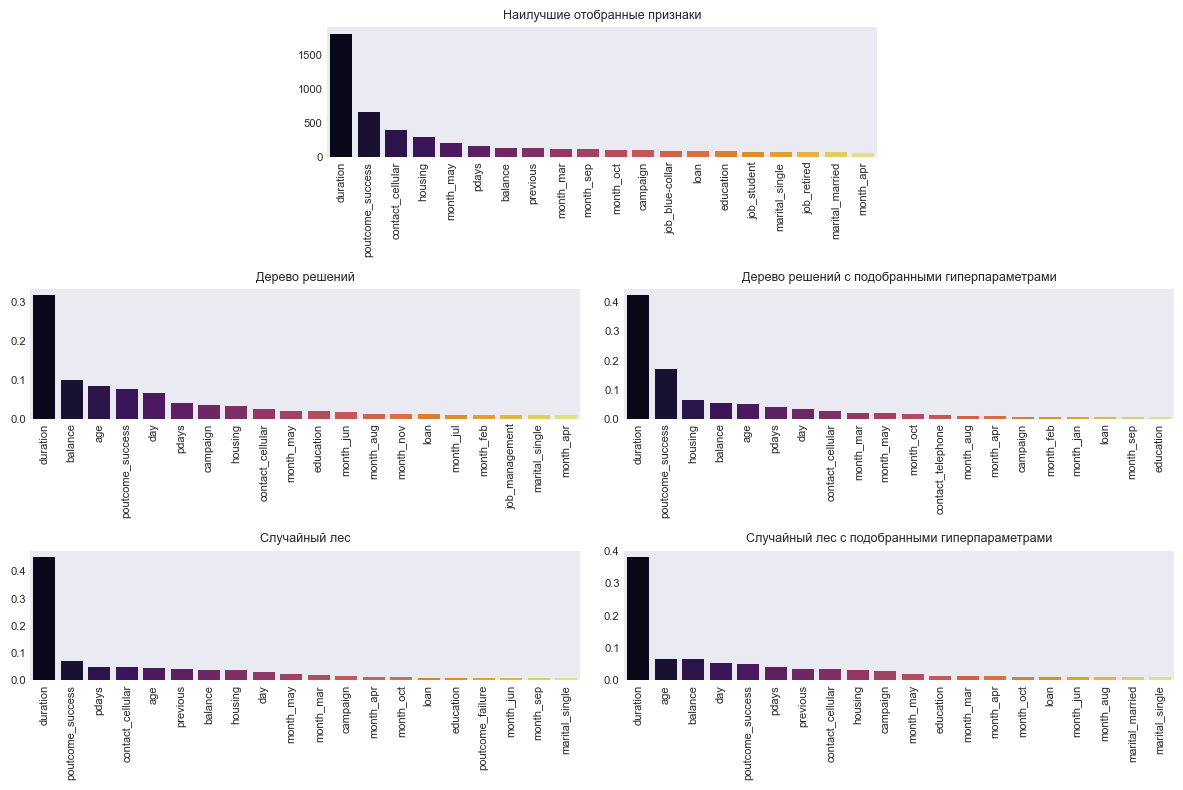

In [633]:
# Barplot procedure
def features_barplot(x, y, ax, title):
    sns.barplot(x=x, y=y, palette='inferno', ax=ax)
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel('')
    ax.set_title(title, fontsize=9)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(3,4,(2,3))
features_barplot(best_features_score.index, best_features_score.values, 
                 ax, 'Наилучшие отобранные признаки')
ax = fig.add_subplot(3,4,(5,6))
features_barplot(list(tree_feature_score.index)[:20], list(tree_feature_score.values)[:20], 
                 ax, 'Дерево решений')
ax = fig.add_subplot(3,4,(7,8))
features_barplot(list(tree_best_feature_score.index)[:20], list(tree_best_feature_score.values)[:20], 
                 ax, 'Дерево решений c подобранными гиперпараметрами')
ax = fig.add_subplot(3,4,(9,10))
features_barplot(list(forest_feature_score.index)[:20], list(forest_feature_score.values)[:20], 
                      ax, 'Случайный лес')
ax = fig.add_subplot(3,4,(11,12))
features_barplot(list(forest_best_feature_sc.index)[:20], list(forest_best_feature_sc.values)[:20], 
                 ax, 'Случайный лес с подобранными гиперпараметрами')

fig.tight_layout()
plt.show();

> * Наилучший результат показала модель случайного леса с параметрами: 100 деревьев глубины 10 с минимальным числом объектов листа равным 5:
>   * F1-score равен 0.86 и 0.84, Accuracy равно 0.87 и 0.85 на обучающей и тестовой выборках для модели, обученной на всех признаках
>   *  F1-score равен 0.85 и 0.83, Accuracy равно 0.86 и 0.84 на обучающей и тестовой выборках для модели, обученной на 20 отобранных признаках 
> * Модели, построенные на гиперпараметрах, подобранных методом GridSearch в случае дерева решений и методом Optuna в случае случайного леса, дают переобученность модели.
> * Наиболее значимым признаков во всех построенных моделях является признак 'duration' - длительность общения с клиентом по телефону во время рекламной кампании.
> * Кроме того, во всех моделях значимыми являются признаки:
>   * 'balance' - баланс клиентов,
>   * 'age' - возраст клиента
>   * 'contact_cellular' - бумажная рассылка в рекламную кампанию,
>   * 'day' - день последнего контакта
>   * 'pdays' - количество дней, прошедших с последнего контакта в предыдущую кампанию до контакта в текущей кампании
>   * 'poutcome_success' - успешный результат в предыдущую кампанию
>   * 'previous' - число контактов в предыдущую кампанию
>   * 'housing' - наличие кредита на жилье
>   * 'month_may' - месяц контакта
>   * 'month_mar' - месяц контакта
>   * 'month_apr'- месяц контакта
>   * 'month_oct'- месяц контакта